# Generazione di *Adversarial Examples* con Tensorflow: Metodologia di attacco *white box* ad una DNN.
## Elaborato per il corso di Analisi Immagini del prof R. Campanini


Più volte in passato è stato dimostrato che deep neural networks (DNNs) come *InceptionV3* di Google, aventi applicazioni pratiche in svariati ambiti, possono essere suscettibili ad *adversarial examples* ottenuti sovrapponendo alle immagini di input delle perturbazioni di ordine inferiore alle feature delle stesse, pertanto invisibili ad occhio umano: input così modificati possono spingere volutamente la rete ad una classificazione erronea. 
L'inapplicabilità di attacchi di questo tipo era, fino a poco tempo fa, oggetto di interesse puramente teorico a causa di due limitazioni fondamentali all'efficacia degli stessi: 
1. **Indisponibilità del modello della rete**: La generazione di rumore avvversariale richiederebbe l'accesso al modello originale della rete e la capacità di poter eseguirvi backpropagation, rendendo impossibile, in teoria, l'esecuzione di un attacco _black box_. Tale difficoltà è in realtà stata recentemente sorpassata con l'uso di reti neurali avversariali che modellizzino la distribuzione della DNN sotto attacco, si veda a tale proposito [_**Generating Adversarial Examples with Adversarial Networks - 22/03/2018**_](https://openreview.net/pdf?id=HknbyQbC-) (l'identità degli autori è al momento sconosciuta poichè il paper è ancora in double-blind review).
2. **Non-robustezza dell'attacco rispetto a piccole trasformazioni degli input**: L'attacco risultava del tutto inefficace nel momento in cui all'immagine avversariale veniva applicata una qualunque trasformazione affine, una semplice rotazione dell'immagine portava l' _adversarial example_ ad essere nuovamente classificato correttamente. Tale ostacolo è anch'esso stato recentemente superato, si legga a tale proposito [_**A. Athalye et al. : Synthetizing Robust Adversarial Examples - 30/10/2017**_](https://arxiv.org/pdf/1707.07397.pdf), paper anch'esso ancora in review. 

Lo scopo di questo elaborato è, oltre alla presentazione di alcune possibili strategie di attacco, l'implementazione una metodologia di robusta rispetto a trasformazioni affini, così come descritta da A. Athalye et al. .

## Adversarial Examples: un modello lineare
La scoperta dell'esistenza di *adversarial examples* ([_**C. Zzegedy et al. : Intriguing Properties of Neural Networks - 19/02/2014**_](https://arxiv.org/pdf/1312.6199.pdf) ) ha portato in tempi recenti alla formulazione di svariate ipotesi sulle possibili cause che originano il fenomeno: nelle primissime settimane dalla scoperta si è assistito alla diffusione di interpretazioni altamente speculative secondo le quali la causa sarebbe da cercarsi nel comportamento estremamente nonlineare delle DNN, possibilmente combinato con un'approssimazione insufficiente della distribuzione di probabilità del modello ed insufficiente regolarizzazione dello stesso con conseguente overfitting ai dati di addestramento. 
Un'interpretazione più attendibile è quella su cui si basa l'approccio usato in questo elaborato ed è ben descritta in [ _**I. Goodfellow et al. : Explaining and Harnessing Adversarial Examples - 20/03/2015**_](https://arxiv.org/pdf/1412.6572.pdf) : secondo tale ricostruzione l'ipotesi di nonlinearità sarebbe, oltre che superflua, del tutto errata, in quanto sarebbe proprio il comportamento lineare in spazi ad alta dimensionalità la condizione sufficiente a generare il fenomeno. Strategie di regolarizzazione generica come _dropout_ o _pre-training_, in tale interpretazione, sarebbero totalmente inefficaci a ridurre la vulnerabilità del modello rispetto a _adversarial examples_, mentre una buona strategia sarebbe il passaggio a reti fortemente nonlineari, come quelle basate su RBF, che tuttavia hanno lo svantaggio di richiedere maggiore sforzo computazionale in fase di addestramento.

### Perchè succede?
Nella maggior parte delle applicazioni pratiche, la precisione associata ad una feature di input è limitata: ad esempio generalmente le immagini digitali vengono convertite ad una profondità di colore a 8-bit così che tutta l'informazione al di sotto dell' $\frac{1}{255}$-esima parte del range dinamico viene automaticamente scartata. Per questo motivo non è ragionevole aspettarsi che un classificatore risponda in modo differente ad un input $ x $ rispetto ad un secondo input $  \hat{x} = x + \eta $ se ogni elemento dell'immagine perturbativa $ \eta $ è più piccolo del limite precisione delle feature ( ex $\frac{1}{255}$-esimo del range dinamico ), infatti ci aspettiamo che sia l'immagine $ x $ che l'immagine $ \hat{x} $ vengano assegnate alla stessa classe fintanto che $ \lVert \eta \rVert_{\infty} < \epsilon $ dove $ \epsilon $ è abbastanza piccolo da poter essere ignorato o dal sensore o dall'apparato di memorizzazione associato al nostro problema.

Si consideri a questo punto il prodotto scalare tra un vettore dei pesi $ w $ e l'esempio $ \hat{x} $ da noi costruito :

$ w^\top \cdot \hat{x} = w^\top \cdot x + w^\top \cdot \eta $

La perturbazione causa l'incremento della funzione di attivazione di una quantità $ w^\top \cdot \eta $: possiamo impostare un problema di massimizzazione vincolata a $ \lVert \eta \rVert_{\infty} < \epsilon $, che può essere risolto banalmente prendendo $ \eta = \text{segno}(w)$. Se $ w $ ha $ n $ dimensioni, e l'ampiezza della singola componente di $ w$  mediata su tutte le dimensioni è $ m$ allora l'incremento della funzione di attivazione sarà $ (w^\top \cdot \eta)_{max} = e m n $.
Visto che $ \lVert \eta \rVert_{\infty} $ non scala con la dimensionalità, ma l'incremento della funzione di attivazione dipende da $ n$ allora si ha che per problemi ad alta dimensionalità la somma di cambiamenti infinitesimali agli input può portare a grandi modifiche degli output.

Questa spiegazione, pur essendo ristretta ad un caso puramente lineare, si generalizza molto bene sia a reti con funzioni di attivazione _ReLU_ o _maxout_, concepite per avere comportamenti lineari, sia a reti non puramente lineari, con funzioni di attivazione di tipo sigmoidale o a tangente iperbolica, che tuttavia operano spesso in regime di non-saturazione, facendo emergere comportamenti in buona approssimazione lineari. 

In [1]:
import os
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt

from mpl_toolkits.axes_grid1 import ImageGrid
import math
import urllib.request
from urllib.request import urlretrieve
import PIL
from PIL import Image, ImageFilter

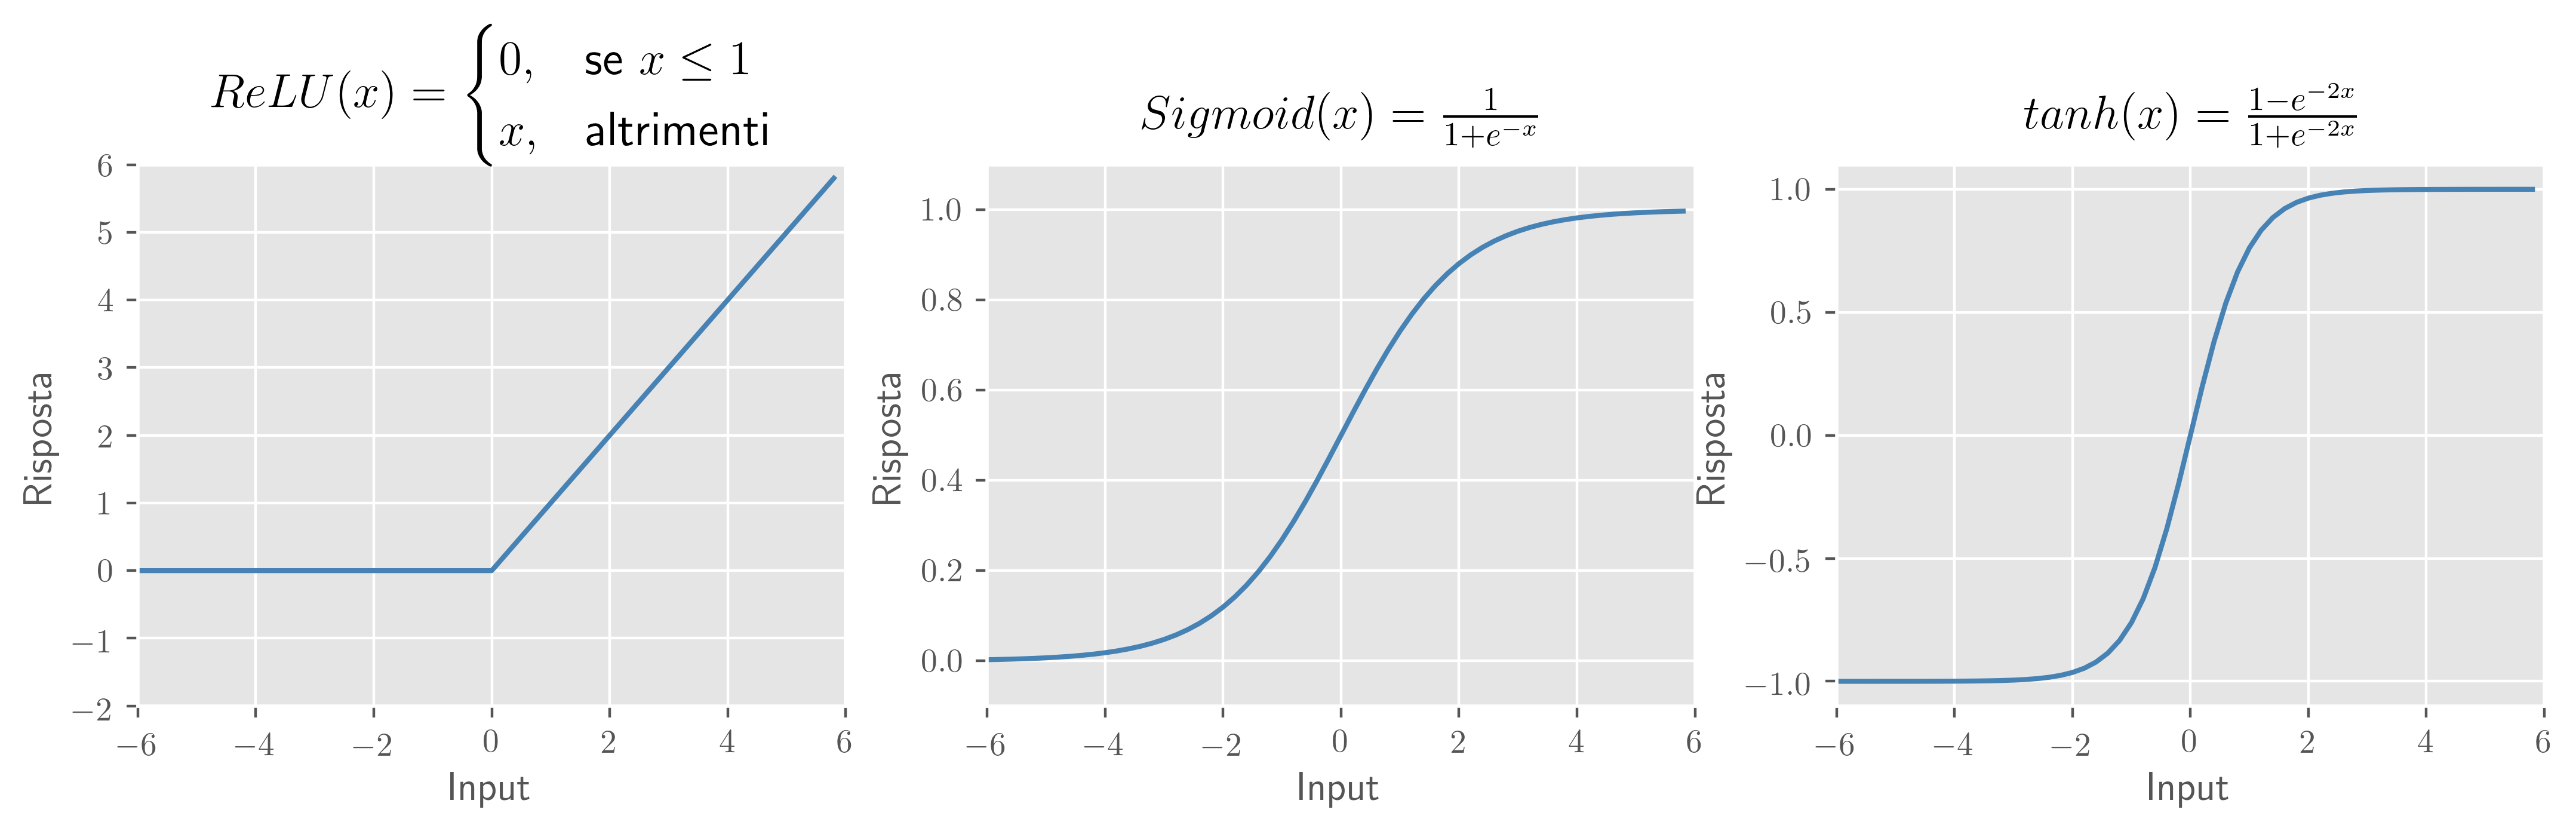

In [2]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['figure.dpi']= 400
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))

t = np.arange(-6., 6., 0.2)

# PLOT RELU
def ReLUplt(i):
    if i <= 0:
        j = 0
    else :
        j = i
    return j
relu_values = [ReLUplt(i) for i in t]


ax1.plot(t, relu_values, color='steelblue')
plt.sca(ax1)
plt.axis([-6, 6, -2, 6])
plt.ylabel('Risposta')
plt.xlabel('Input')
plt.title(r"$ReLU(x)= \begin{cases} 0 ,& \text{se }  x \leq 1\\  x, & \text{altrimenti}  \end{cases}$")

def sigmoidplt(i):
    return 1 / (1 + math.exp(-i))
sigmoid_values = [sigmoidplt(i) for i in t]


ax2.plot(t, sigmoid_values, color='steelblue')
plt.sca(ax2)
plt.axis([-6, 6, -.1, 1.1])
plt.ylabel('Risposta')
plt.xlabel('Input')
plt.title(r"$Sigmoid(x)= \frac{1}{1+e^{-x}}$")

tanh_values = [math.tanh(i) for i in t]
ax3.plot(t, tanh_values, color='steelblue')
plt.sca(ax3)
plt.axis([-6, 6, -1.1, 1.1])
plt.ylabel('Risposta')
plt.xlabel('Input')
plt.title(r"$tanh(x)= \frac{1-e^{-2x}}{1+e^{-2x}}$")
plt.show()

### Generazione degli esempi: 

Prendiamo quindi come vera l'ipotesi che le reti operino in modo sufficientemente lineare da non poter ignorare una perturbazione lineare del tipo descritto sopra, vediamo come sfruttare questa assunzione per generare del rumore avversariale.

Utilizziamo la seguente notazione:
1. Sia $X$ l'immagine di input, tipicamente un tensore 3-D (altezza x larghezza x canali), assumiamo che le immagini siano in formato 8-bit in cui i pixel assumono valori nel range $[0, 255]$
2. $y_{true}$ sia la vera classe di appartenenza dell'immagine $X$
3. $J(X,y)$ sia la _cross entropy cost function_  del classificatore, data un'immagine $ X $ ed una classe $ y $. Si omette volutamente, in questa notazione, la dipendenza dai pesi sinaptici e dai parametri della rete ( altrimenti sarebbe $ J(\theta, X, y) $ ) ad indicare l'assunzione che questi siano fissati nel contesto dell'attacco. In reti neurali il cui gli output siano normalizzati con metodo _softmax_, la _cross-entropy cost function_ equivale alla _log-probabilità_ negativa della _vera_ classe $ y_{true} $ data l'immagine $X$: $J(X,y) = - \log{p\left(y\mid X\right)}$.
4. $\text{Clip}_{X, \epsilon}\{\hat{X}\}$ è una funzione che esegua il _clipping_ pixel-wise del tensore $\hat{X}$ in modo tale che il risultato risulti nella sfera di raggio $ \lVert \epsilon \rVert_{\infty}$ centrata in $ X$, funzione definita come $\text{Clip}_{X, \epsilon}\{\hat{X}\}(x,y,z) = min \{ 255, X(x,y,z) + \epsilon, max \{ 0, X(x,y,z) - \epsilon, \hat{X}(x,y,z) \} \}$ dove $ X(x,y,z)$ è il valore del canale $z$ dell'immagine $ X $ in corrispondenza delle coordinate $ (x,y) $.

#### Metodo FSGM (Fast Gradient Sign Method - I. Goodfellow et al.) 
Il metodo più semplice per generare _adversarial examples_ è quello di linearizzare la funzione di costo e risolvere il problema di massimizzazione della stessa rispetto agli incrementi $\eta$ con vincolo $ \lVert \eta \rVert_{\infty} < \epsilon $. Questo può essere fatto efficacemente utilizzando la _backpropagation_ sulla _cross-entropy cost function_ ( che ricordiamo essere equivalente alla probabilità a posteriori di $y$ data $X$ ).

$\hat{X}= X + \epsilon \text{ sign}(\nabla_x{J(X, y_{true})})$

$ \epsilon $ può essere variato per ottenere risultati più o meno visibili ad un osservatore umano.  Questo metodo non richiede una procedura iterativa ma una sola chiamata alla _back-propagation_ ed è il più veloce tra i metodi proposti.

#### Metodo Iterativo #1
Il metodo sopra può essere migliorato in stile iterativo applicandolo multiple volte con uno _step size_ minore di $ \epsilon$ ed applicando a tutti i passaggi intermedi la funzione Clip per assicurarsi che il risultato rimanga in un intorno $ \lVert \epsilon \rVert_{\infty} $ dell'immagine originale:

$\hat{X}_0 = X$, $\hat{X}_{N+1} = \text{Clip}_{X, \epsilon}\{ \hat{X}_N + \alpha \text{ sign} ( \nabla_x J(\hat{X}_N , y_{true})) \} $

$\alpha$ può essere variato per cambiare l'ampiezza degli step, ad esempio $ \alpha = 1 $ indica che il valore di ogni pixel può essere cambiato solo di 1 ad ogni iterazione.

#### Metodo Iterativo #2: Iterative Least-likely Class Method - A. Kurakin et al.
Entrambi i metodi precedenti incrementano la funzione di costo della classe corretta senza specificare quale, tra le classi non corrette, sia quella da selezionare. Specificare una particolare classe in cui classificare erroneamente l'input, oltre che alla potenziale utilità in uno scenario di attacco, è necessario quando si considerino reti con classi particolarmente simili e vicine tra di loro: se un classificatore basato sul dataset _MNIST_ ( cifre manoscritte da 0 a 9 ) presenta classi molto distinte tra di loro ed un errore di classificazione può portare a conseguenze interessanti ( un ipotetico classificatore di assegni manoscritti potrebbe scambiare un assegno da 00001,00 € per uno da 90001,00 € con conseguenze molto tangibili sia per il generoso sig Rossi, traente dell'assegno che per il fortunato sig. Neri, beneficiario ), un classificatore basato su _ImageNet_ presenta invece classi molto più simili e vicine tra di loro e di conseguenza gli errori commessi sarebbero meno interessanti ( farebbe poca notizia se un'automobile a guida automatica scambiasse un cane pastore tedesco per un dobermann, fintanto che lo eviti, ma se Otto, cane del Sig. Rossi, venisse investito perchè classificato come parte della carreggiata le conseguenze sarebbero decisamente più evidenti ). 

Possiamo prendere come classe desiderata quella a minor probabilità secondo la predizione del modello dall'immagine $X$, $ y_{L L} = \text{argmin}_y \{ p \left( y \mid X \right) \} $, aspettandoci che questa sia ben diversa dalla classificazione originale.  Per creare un'immagine avversariale che venga classificata come $ y_{L L }$ massimiziamo la log-probabilità $ \log{p\left(y_{L L} \mid X\right)}$ facendo step iterativi verso la direzione rappresentata da $ \text{sign} \{ \nabla_x \log{p\left(y_{L,L} \mid X\right)} \}=  \text{sign} \{ - \nabla_x J (X, y_{L,L}) \} $ dove l'uguaglianza vale per reti neurali con funzione di costo _cross-entropy_. Possiamo quindi procedere iterativamente con:

$\hat{X}_0 = X$, $\hat{X}_{N+1} = \text{Clip}_{X, \epsilon}\{ \hat{X}_N - \alpha \text{ sign} ( \nabla_x J(\hat{X}_N , y_{L L})) \} $

tale procedura, notiamo, è praticamente identica alla precedente, ad eccezione dell'argomento della funzione di costo e di un segno - davanti allo step.

Per facilitare il collegamento col prossimo paragrafo notiamo come il problema presentato sia perfettamente equivalente al problema di massimizzazione della _log-likelihood_ $ P\left(y_{L L} \mid X \right) $ della classe $y_{L L}$ vincolata su una sfera di raggio $\lVert \epsilon \rVert_{\infty}$ attorno all'immagine originale: $\hat{X} = \text{argmax}_{X'} \log{P\left(y_{L L} \mid X'\right)} $ con $ \lVert X' - X \rVert_{\infty} < \epsilon $


#### Metodo Iterativo #4 : EOT ( Expectation Over Transformation - A. Athalye et al. )

Siamo giunti ad un metodo che ci permetta di forgiare _adversarial examples_ per una classe di nostra scelta, ma, fortunatamente per Sig. Rossi, per le sue finanze e per il suo pastore tedesco Otto, i metodi descritti finora non riescono a generare esempi avversariali che rimangano tali sotto trasformazioni affini ( si vedano a tal proposito [_**J. Lu et al. : NO Need to Worry about Adversarial Examples in Object Detection in Autonomous Vehicles- 12/07/2017**_](https://arxiv.org/pdf/1707.03501.pdf) e [_**Y. Luo et al. : Foveation-based Mechanisms Alleviate Adversarial Examples- 19/01/2016**_](https://arxiv.org/pdf/1511.06292.pdf) ). Sfortunatamente per Otto ed il Sig. Rossi, a meno di una settimana dall'uscita del paper che annunciava la loro sicurezza stradale, compare un metodo, _EOT: Expectation Over Transformation_, presentato da Athalye et al. che promette robustezza rispetto a trasformazioni affini: l'idea che vi sta dietro è quella di modellizzare le trasformazioni che l'immagine avversariale potrebbe avere in un sistema di acquisizione reale già all'interno della procedura di ottimizzazione. 

Invece che ottimizzare la _log-likelihood_ di un singolo esempio EOT usa una distribuzione $T$ di funzioni $t$ , $ X' \rightarrow t(X') $ che trasformino gli input avversariali generati X' nelle loro controparti _"reali"_ percepite effettivamente dal classificatore.
Invece che utilizzare il vincolo $ \lVert X' - X \rVert_{\infty} < \epsilon $ nello spazio delle soluzioni _EOT_ utilizza una _distanza effettiva_ tra gli input originali e gli esempi avversariali

$ \delta = \mathbb{E}_{t \sim T}[d(t(X) - t(X'))]$

EOT risolve allora il seguente problema di ottimizzazione:

$ \hat{X} = \text{argmax}_{X'} \mathbb{E}_{t \sim T} [ \log{P(y \mid t(X'))}] $ con vincolo $ \mathbb{E}_{t \sim T}[d(t(X),t(X'))] < \epsilon $

Il problema può essere risolto tramite _gradient-descent_ notando che $\nabla \mathbb{E}_{t \sim T} \log p\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ è pari a $\mathbb{E}_{t \sim T} \nabla \log p\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ facendo sampling dalla distribuzione delle trasformazioni ad ogni step del _gradient-descent_.

Nella pratica $ T $ può modellizzare trasformazioni che possiamo trovare in un sistema di acquisizione quali rotazioni, traslazioni o anche aggiunta di rumore: le potenzialità di questo metodo si estendono, oltre che alle trasformazioni affini, a qualsiasi distribuzione di trasformazioni $ Q(.;x) $ parametrizzata dall'esempio generato $ X $ fintanto che $ \frac{dQ}{dX} $ è ben definita. La funzione obiettivo può essere quindi ottimizzata approssimando il valore atteso, differenziando attraverso le trasformazioni di $Q$ e utilizzando una metodologia di _gradient descent_.

## Attacco ad una Rete Convolutiva Addestrata su MNIST
## Setup:

Proviamo a vedere come le metodologie sopra descritte possono essere applicate ad una rete neurale convolutiva. A tale proposito addestriamo una rete che partendo da immagini 28x28 monocromatiche di cifre manoscritte riesca a classificarle in 10 classi ( 0 - 9 ).

La rete che vogliamo addestrare sarà composta dei seguenti layer:

**Immagine** $\rightarrow$ **Convoluzione 5x5,32 ** $\rightarrow_{ReLU}$ **Max-Pooling 2x2, (2,2)** $\rightarrow$ **Convoluzione 5x5,64 ** $\rightarrow_{ReLU}$ **Max-Pooling 2x2, (2,2)**  $\rightarrow$ **Completamente Connesso 7x7x64** $\rightarrow_{ReLU}$ **Dropout** $\rightarrow$ **Completamente Connesso 1024** $\rightarrow_{SoftMax}$ **Output 10**

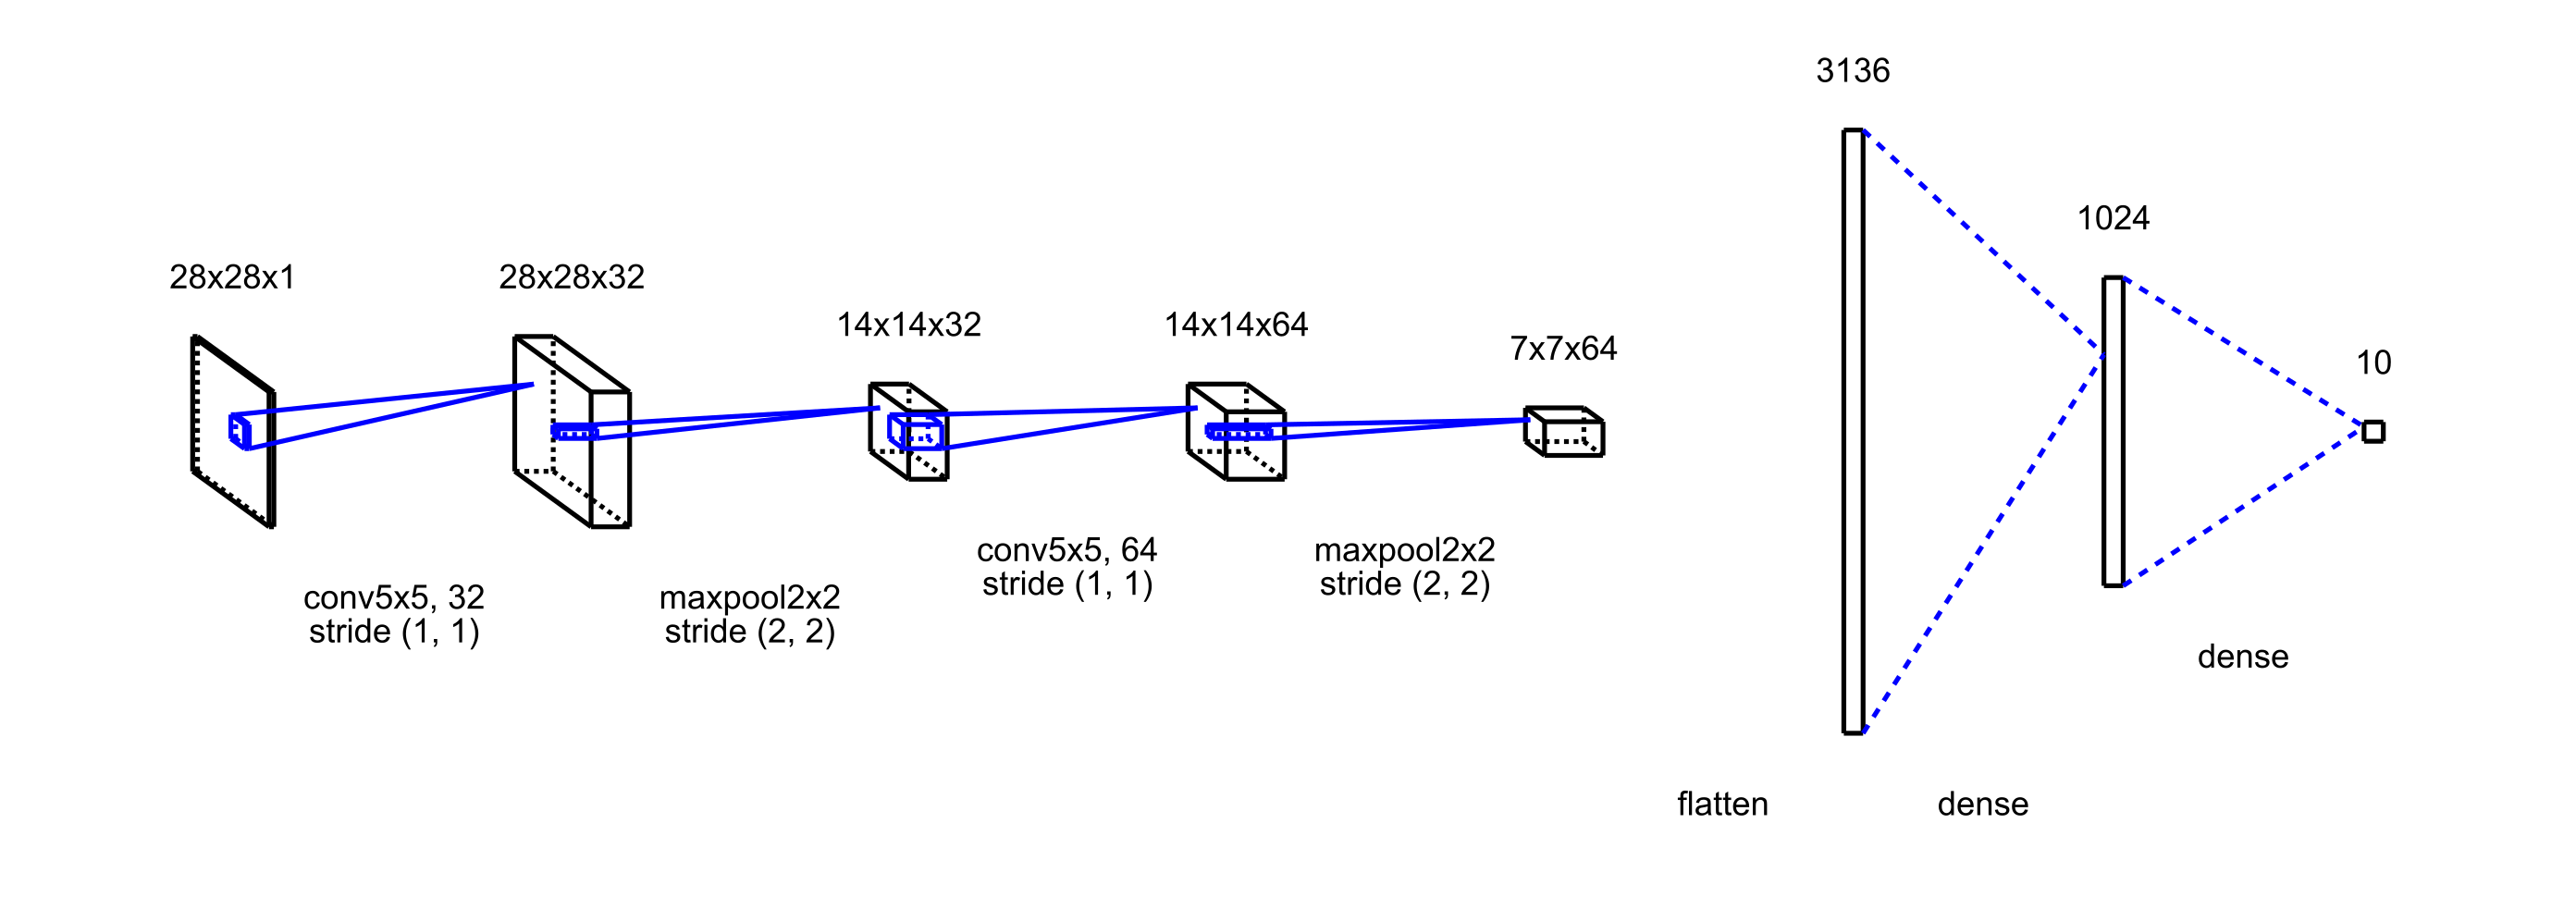

In [3]:
img_path2, _ = urlretrieve('https://raw.githubusercontent.com/filippocastelli/Analisi_Immagini/master/img/rete_mnist.png')
PIL.Image.open(img_path2)

( immagine generata con l'utilissimo strumento [_**convnet-drawer**_](https://github.com/yu4u/convnet-drawer) )

In [ ]:
import tensorflow as tf

Il dataset MNIST è già accuratamente ripulito e disponibile nell'installazione base di TensorFLow in `tensorflow.examples.tutorials.mnist`, carichiamolo specificando che le label sono in formato _one-hot_:

In [ ]:
from __future__ import print_function

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

mnistsess = tf.InteractiveSession()

Definiamo alcune funzioni utili:
1. In primis una funzione, `weight_variable`, per inizializzare i valori dei pesi sinaptici a numeri estratti da una distribuzione normale troncata a valori non negativi: questo velocizzerà l'apprendimento ed eviterà che nella backrpopagation appaiano gradienti con valori divergenti.
2. Con `bias_variable` inizializziamo i bias a valori positivi.
3. Due funzioni, `conv2d()` e `max_pool_2x2()` che ci aiuteranno a definire gli strati della rete neurale interfacciandosi a `tf.nn.conv2d()` e `tf.nn.max_pool()`:

In [6]:
def weight_variable(shape):
    #inizializzo i pesi ad un valore random non-negativo
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    #inizializzo i bias ad un valore positivo
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    #passo pari a 1, padding = "SAME": si aggiungono zeri per ottenere
    # un'immagine dele dimensioni originali
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# finestra pooling e strides uguali
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

La funzione `tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')` calcola l'operatore di colvoluzione bidimensionale dell'immagine `x` col filtro `W`, usando come passo `strides` e modalità di padding `padding`. 

Da notare che sia `x` che `W` sono tensori quadridimensionali: 

1. `x` è un tensore di dimensioni `[-1, 28, 28, 1]` dove il `-1` in corrispondenza della dimensione della prima componente indica che questa viene calcolata dinamicamente in base alla dimensione della _batch_ di immagini che processiamo contemporaneamente, il numero di pixel di ogni immagine è 28x28 =784, ed il numero di canali di ogni immagine è 1.
2. `W` invece, per il primo strato convolutivo, ha dimensioni `[5, 5, 1, 32]`: possiamo vedere 5x5 come la dimensione del kernel di convoluzione, 1 come la profondità dello strato di input e 32 come il numero di filtri convolutivi che stiamo applicando.

`strides` invece è un vettore che indica la larghezza del passo con cui il _kernel_ di convoluzione scorre sull'immagine: in questo caso è pari a `[1, 1, 1, 1]` indicando che il _kernel_ viene applicato scorrendo su ogni dimensione dello strato di input, scorrendo i pixel di 1 in 1 su entrambe le dimensioni, su ogni filtro convolutivo.

Per quanto riguarda la modalità di _padding_, `tf.nn.conv2d()` al momento supporta solo la modalità `'SAME'` e la modalità `'VALID'`:

Un  _padding_ di tipo _same_ aggiunge colonne x ed y di zeri all'immagine in modo che la dimensione dell'immagine convoluta sia la stessa dell'immagine originale:

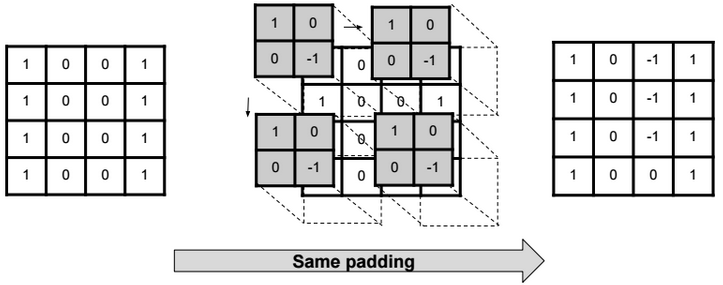

In [7]:
samepadding_img, _ = urlretrieve('http://sqlml.azurewebsites.net/wp-content/uploads/2017/09/null-26.png')
PIL.Image.open(samepadding_img)

Un _padding_ di tipo _null_ o _valid_ non inserisce colonne aggiuntive, in questo modo la dimensione dell'immagine convoluta è minore dell'immagine originale e dipenderà dalle dimensioni del _kernel_ e dagli _stride_ utilizzati:

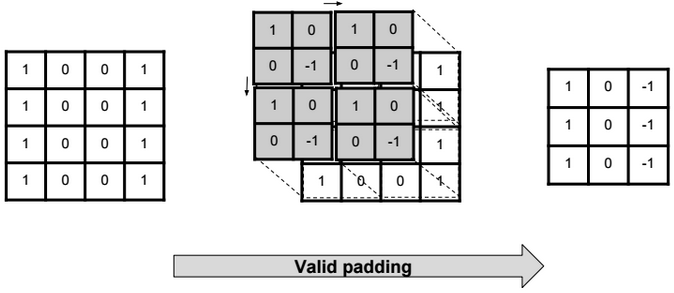

In [8]:
nullpadding_img, _ = urlretrieve('http://sqlml.azurewebsites.net/wp-content/uploads/2017/09/null-27.png')
PIL.Image.open(nullpadding_img)

`tf.nn.max_pool()` invece effettua un _max-pooling_ ovvero, scorrendo con passo `[1, 2, 2, 1]` sull'immagine, calcola il valore massimo su una finestra di dimensioni `[1, 2, 2, 1]`; viene applicato ancora lo stesso tipo di _pooling_ per non ridurre le dimensioni dell'output.

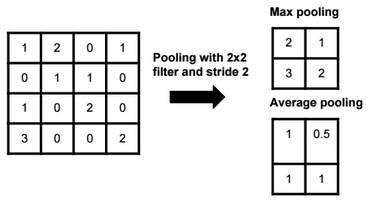

In [9]:
maxpooling_img, _ = urlretrieve('http://sqlml.azurewebsites.net/wp-content/uploads/2017/09/null-28.png')
PIL.Image.open(maxpooling_img)

( le tre precedenti immagini sono prese in prestito da [_**SQML - Convolutional Neural Networks**_](http://sqlml.azurewebsites.net/2017/09/12/convolutional-neural-network/) in modo non del tutto consensuale, non denunciatemi pls )

`tf.nn.dropout(h_fc1, keep_prob)` per ogni valore di `h_fc1` restituisce con probabilità `keep_prob` il valore moltiplicato per 1 /`keep_prob` stesso, altrimenti restituisce 0. La moltiplicazione serve a mantenere costante la somma attesa. 

definiamo la struttura della nostra rete:

In [10]:
# Strato Input
x  = tf.placeholder(tf.float32, [None, 784], name='x') #dati
y_ = tf.placeholder(tf.float32, [None, 10],  name='y_') #label

# il -1 nella prima dimensione indica che quella particolare dimensione è 
# calcolata da TensorFlow a posteriori, in questa maniera posso ampliare la batch.
x_image = tf.reshape(x, [-1, 28, 28, 1]) #le immagini sono 28x28, monocromatiche.

# Primo Strato Convolutivo
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# Output
# relu -> pooling
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Secondo Strato Convolutivo
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# Output 
# relu -> pooling
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Primo Totalmente Connesso
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob  = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Secondo Totalmente Connesso 
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

# Output

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
y = tf.nn.softmax(y_conv)

La funzione di costo è la cross-entropy: $ H (p,q) = -\sum_{x_i}{\hat{y}(x_i)\log{y(x_i)}}$ dove le $\hat{y}(x_i)$ sono le label e le $y(x_i)$ sono le predizioni del modello.

In [ ]:
# Funzione loss:

# si sarebbe potuto usare
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# tuttavia
# TensorFlow mette a disposizione anche la funzione tf.nn.softmax_cross_entropy_with_logits()

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))

# definiamo anche un indice di accuratezza per tenere d'occhio il training
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Creiamo uno step di training che minimizzi la quantità `cross_entropy` utilizzando il metodo di ottimizzazione **_Adam_** ( si legga [_**D.P. Kingma, J. Lei Ba - Adam: a Method for Stochastic Optimization**_](https://arxiv.org/pdf/1412.6980.pdf) ), pià efficiente rispetto ad una classica gradient-descent.

In [12]:
# Algoritmo di Training Adam
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Ultimi preparativi: inizializziamo tutte le variabili globali e impostiamo un `tf.train.Saver()` per poter i risultati del training in un file `.ckpt`. 

In [13]:
# Inizializziamo le variabili globali
mnistsess.run(tf.global_variables_initializer())
# creiamo un Saver per poter salvare i risultati dell'addestramento
mnist_saver = tf.train.Saver()

Iniziamo il training vero e proprio: utilizziamo un numero di step pari a `mnist_steps` e forniamo i dati all'ottimizzatore in batch da `200` immagini l'una, ogni 200 iterazioni stampiamo il valore della funzione di costo media calcolata sulla batch attuale per avere una stima del progresso del modello.

In [14]:
# Train model

mnist_steps = 1000
mnist_batch_size = 200

for i in range(mnist_steps):
    #facciamo batch da 200 immagini
    batch = mnist.train.next_batch(mnist_batch_size)
    #ogni 200 
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, precisione %g"%(i, train_accuracy))
    # ottimizzatore Adam
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})
    
#salviamo i risultati
mnist_save_path = mnist_saver.save(mnistsess, "./mnist.ckpt")

step 0, precisione 0.1
step 200, precisione 0.945
step 400, precisione 0.945
step 600, precisione 0.94
step 800, precisione 0.96


Il modello è ora addestrato: un'accuratezza del 96% sul dataset MNIST è in realtà considerata abbastanza bassa ma è un ottimo risultato se si considera che abbiamo addestrato il modello solo per pochi minuti!

Col modello funzionante possiamo ora creare una funzione che ci permetta di utilizare la rete per classificare input di nostra scelta e plottarli con le relative classi previste e probabilità stimate:

In [15]:
def plot_predictions(image_list, output_probs=False, adversarial=False):

    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Imposto grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(rows, cols),  
                     axes_pad=0.5,
                     )
    
    # Ricava probablità, immagini e popola la griglia
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) 
        pct_list[i] = prob[i][pred_list[i]] * 100 #formato percentuale
        

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)

        grid[i].set_title('Label: {0} \nConfidenza: {1}pct.' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        major_ticks = np.arange(-0.5, 27.5, 7)
        minor_ticks = np.arange(-0.5, 27.5, 1)
        
        grid[i].set_xticks(major_ticks)
        grid[i].set_xticks(minor_ticks, minor=True)
        grid[i].set_yticks(major_ticks)
        grid[i].set_yticks(minor_ticks, minor=True)
        grid[i].set_yticklabels([])
        grid[i].set_xticklabels([])
        grid[i].grid(which='minor', alpha=0.2)
        grid[i].grid(which='major', alpha=0.5)

        #grid[i].grid(False)
        # Modalità Immagini Avversariali
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Derivate \nParziali")
        
    plt.show()
    
    #ritorno probabilità se flag attivo
    return prob if output_probs else None

Per provare il modello selezioniamo 10 immagini che rappresentino la cifra "2" stando attenti a sceglierle non dal training set `mnist.train.images` ma dal gruppo di immagini `mnist.test.images` che non sono state usate in fase di training.

In [16]:
#prendo 10 immagini di 2 dalle immagini di test MNIST
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:10]
x_batch = mnist.test.images[index_of_2s]

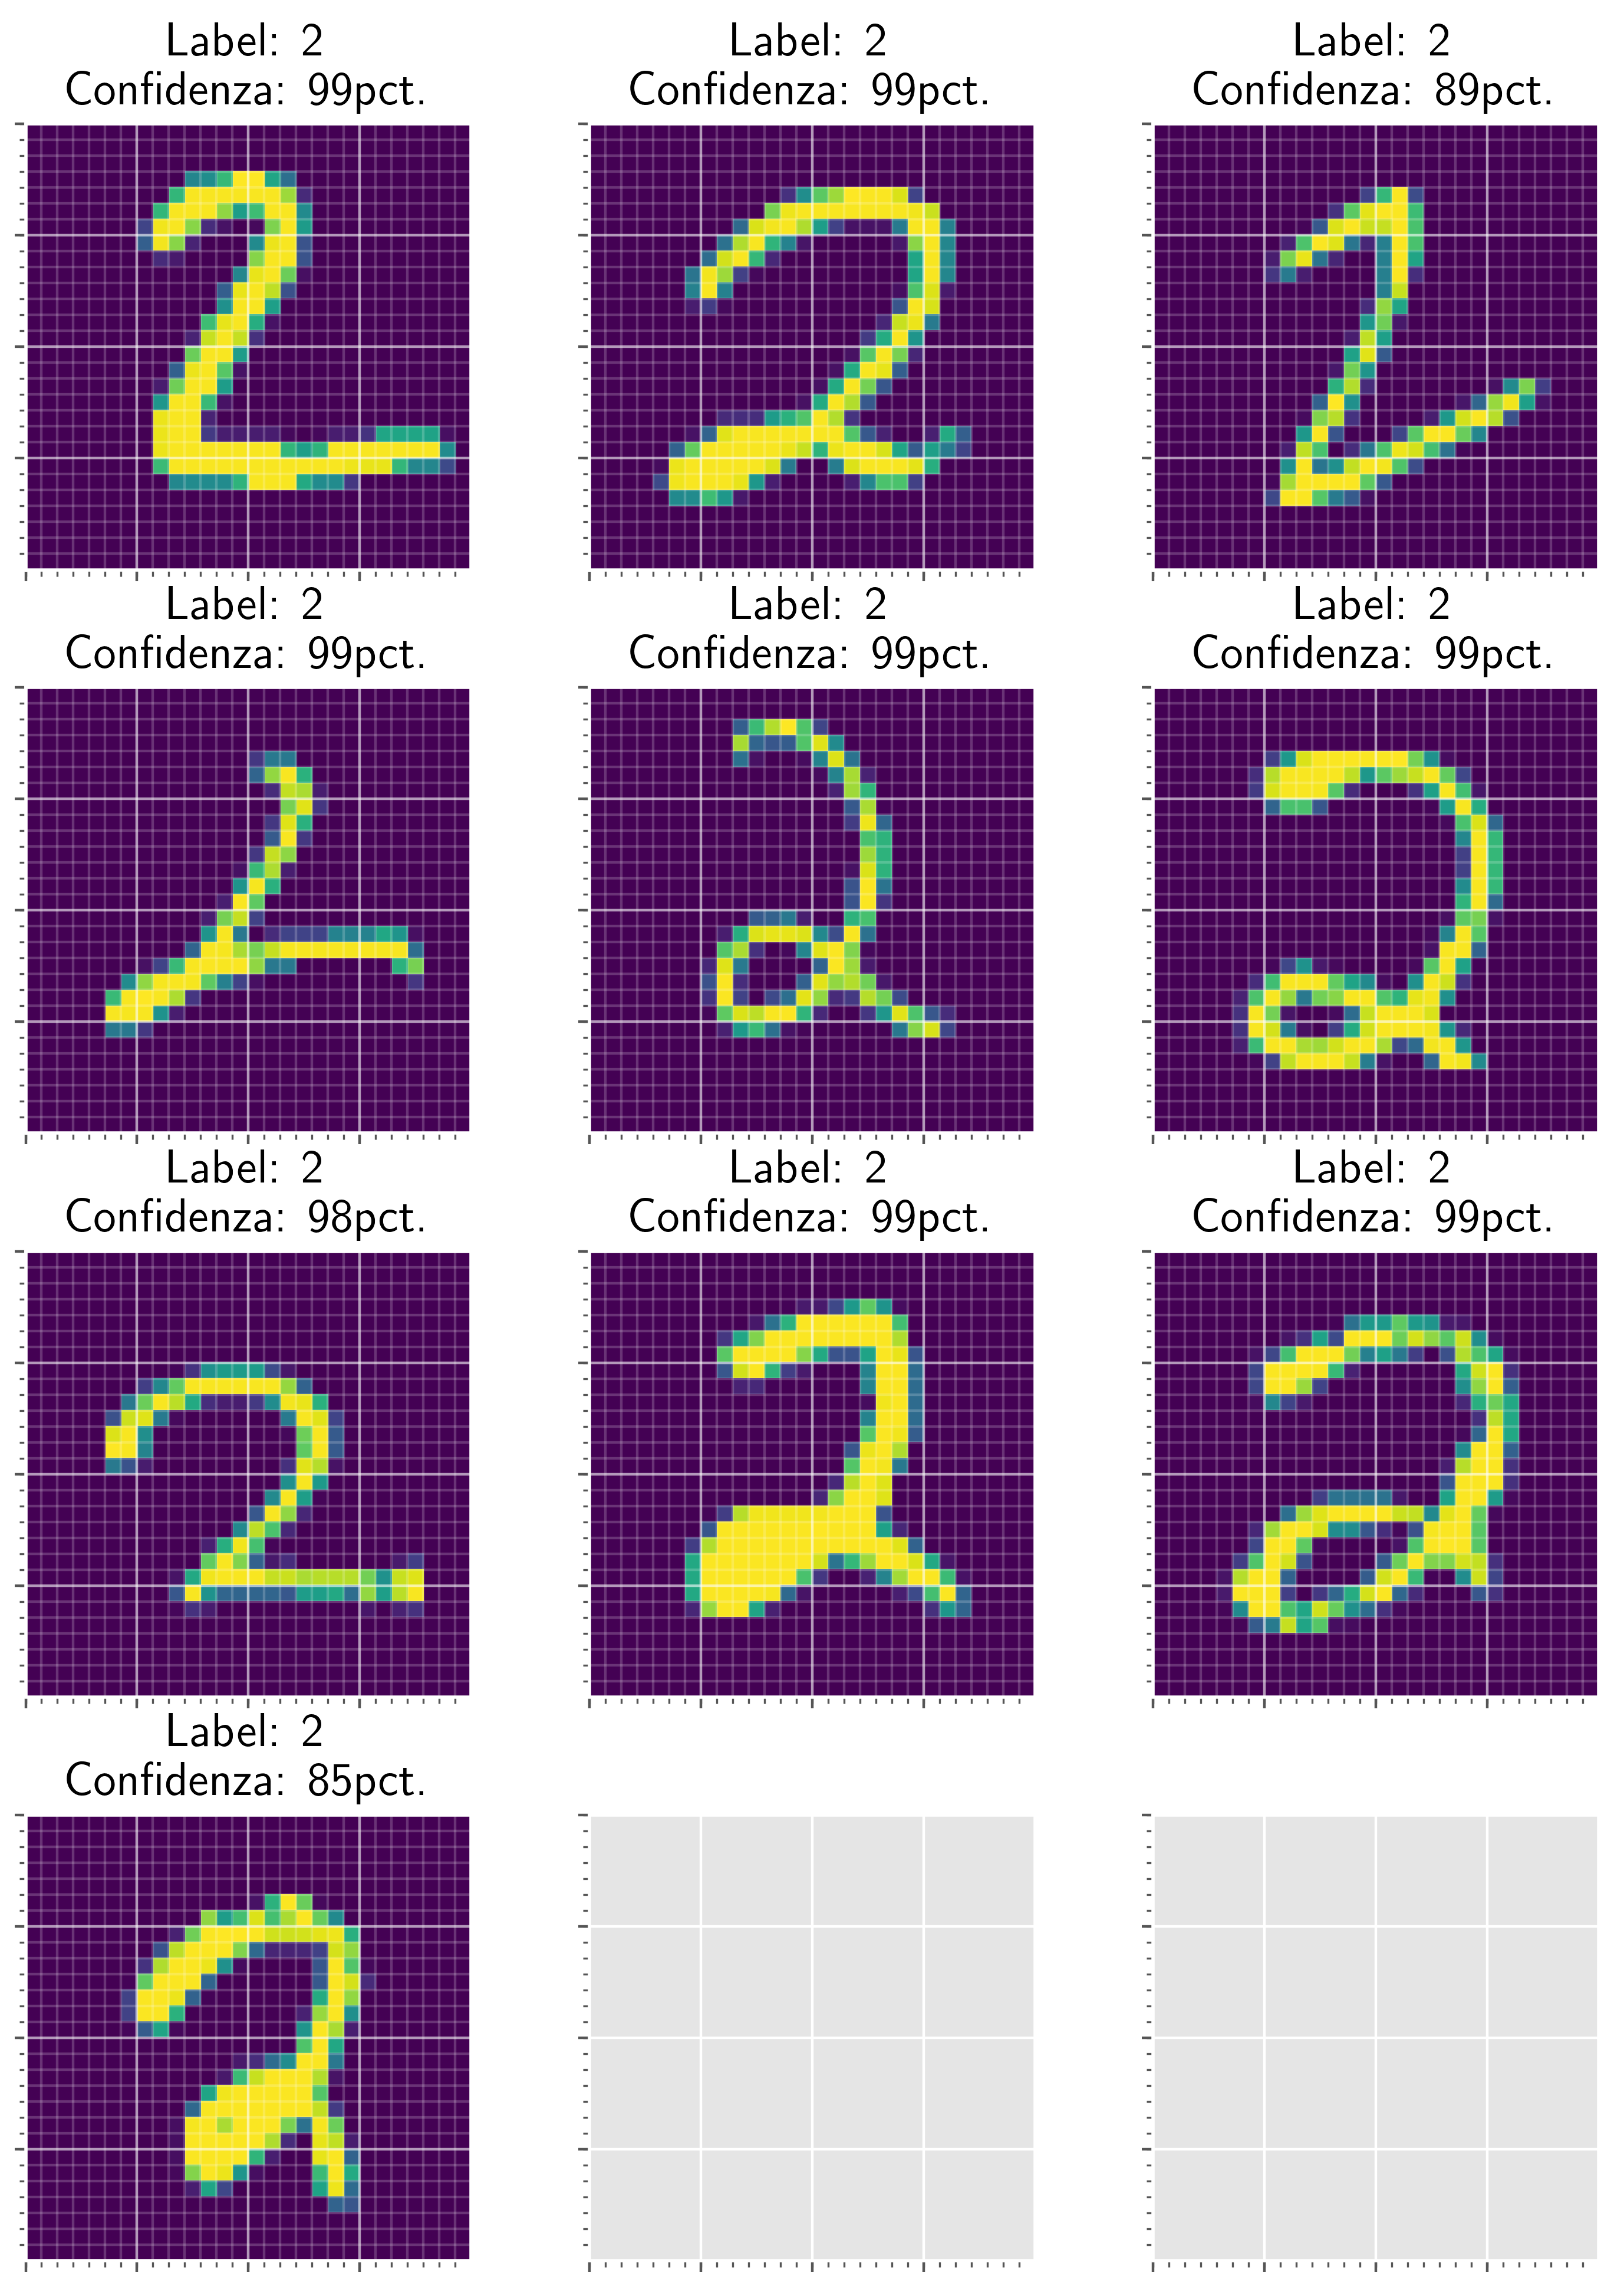

In [17]:
plot_predictions(x_batch)

Possiamo utilizzare il modello anche per riconoscere un carattere manoscritto fornito da noi:
in primis scriviamo una funzione che modifichi l'immagine in un formato che possa essere usato come input della rete (28x28, monocromatico).

In [18]:
def imageprepare(argv):
    
    # converto l'immagine in monocromatico 8-bit
    im = Image.open(argv).convert('L')
    
    #applico una threshold
    threshold = 113
    im = im.point(lambda p: p > threshold and 255)
    
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255)) #crea una canvas 28x28 pixel
    
    if width > height: #guarda quale è dimensione maggiore
        #se la larghezza è maggiore la ridimensiono
        nheight = int(round((28.0/width*height),0)) 
        if (nheight == 0): #l'altezza minima deve essere 1px
            nheigth = 1  
        # ridimensiono e aumento contrasto.
        img = im.resize((28,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight)/2),0)) #calcolo posizione orizzontale
        newImage.paste(img, (0, wtop)) #scrivo immagine sulla canvas
    else:
        #Altezza maggiore, operazione analoga alla prima
        nwidth = int(round((28.0/height*width),0)) #ridimensiono in accordo alla larghezzza
        if (nwidth == 0): #1px minimo
            nwidth = 1
         # ridimensiono e aumento contrasto
        img = im.resize((nwidth,28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth)/2),0)) #calcolo posizione verticale
        newImage.paste(img, (wleft, 0)) #scrivo immagine su canvas
        
    #newImage.save("sample.png")

    tv = list(newImage.getdata()) #valori pixel
    
    #normalizzo: 0 è bianco e 1 è nero (formato standard mnist)
    tva = [ (255-x)*1.0/255.0 for x in tv] 
    return tva

Scarichiamo l'immagine di una cifra manoscritta da una GitHub che ho appositamente creato:

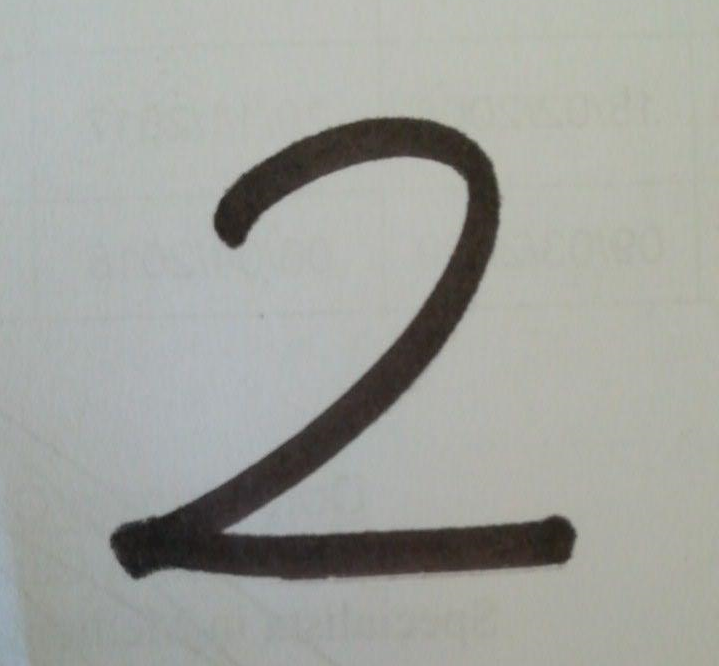

In [19]:
handwritten_number, _ = urlretrieve('https://raw.githubusercontent.com/filippocastelli/Analisi_Immagini/master/img/2.png')
#handwritten_number, _ = urlretrieve('https://raw.githubusercontent.com/filippocastelli/Analisi_Immagini/master/img/3.png')
#handwritten_number, _ = urlretrieve('https://raw.githubusercontent.com/filippocastelli/Analisi_Immagini/master/img/9.png')
PIL.Image.open(handwritten_number)

processiamola con la funzione `imageprepare()` che abbiamo appena definito ed aggiungiamola alla lista di esempi che abbiamo precedentemente scelto.

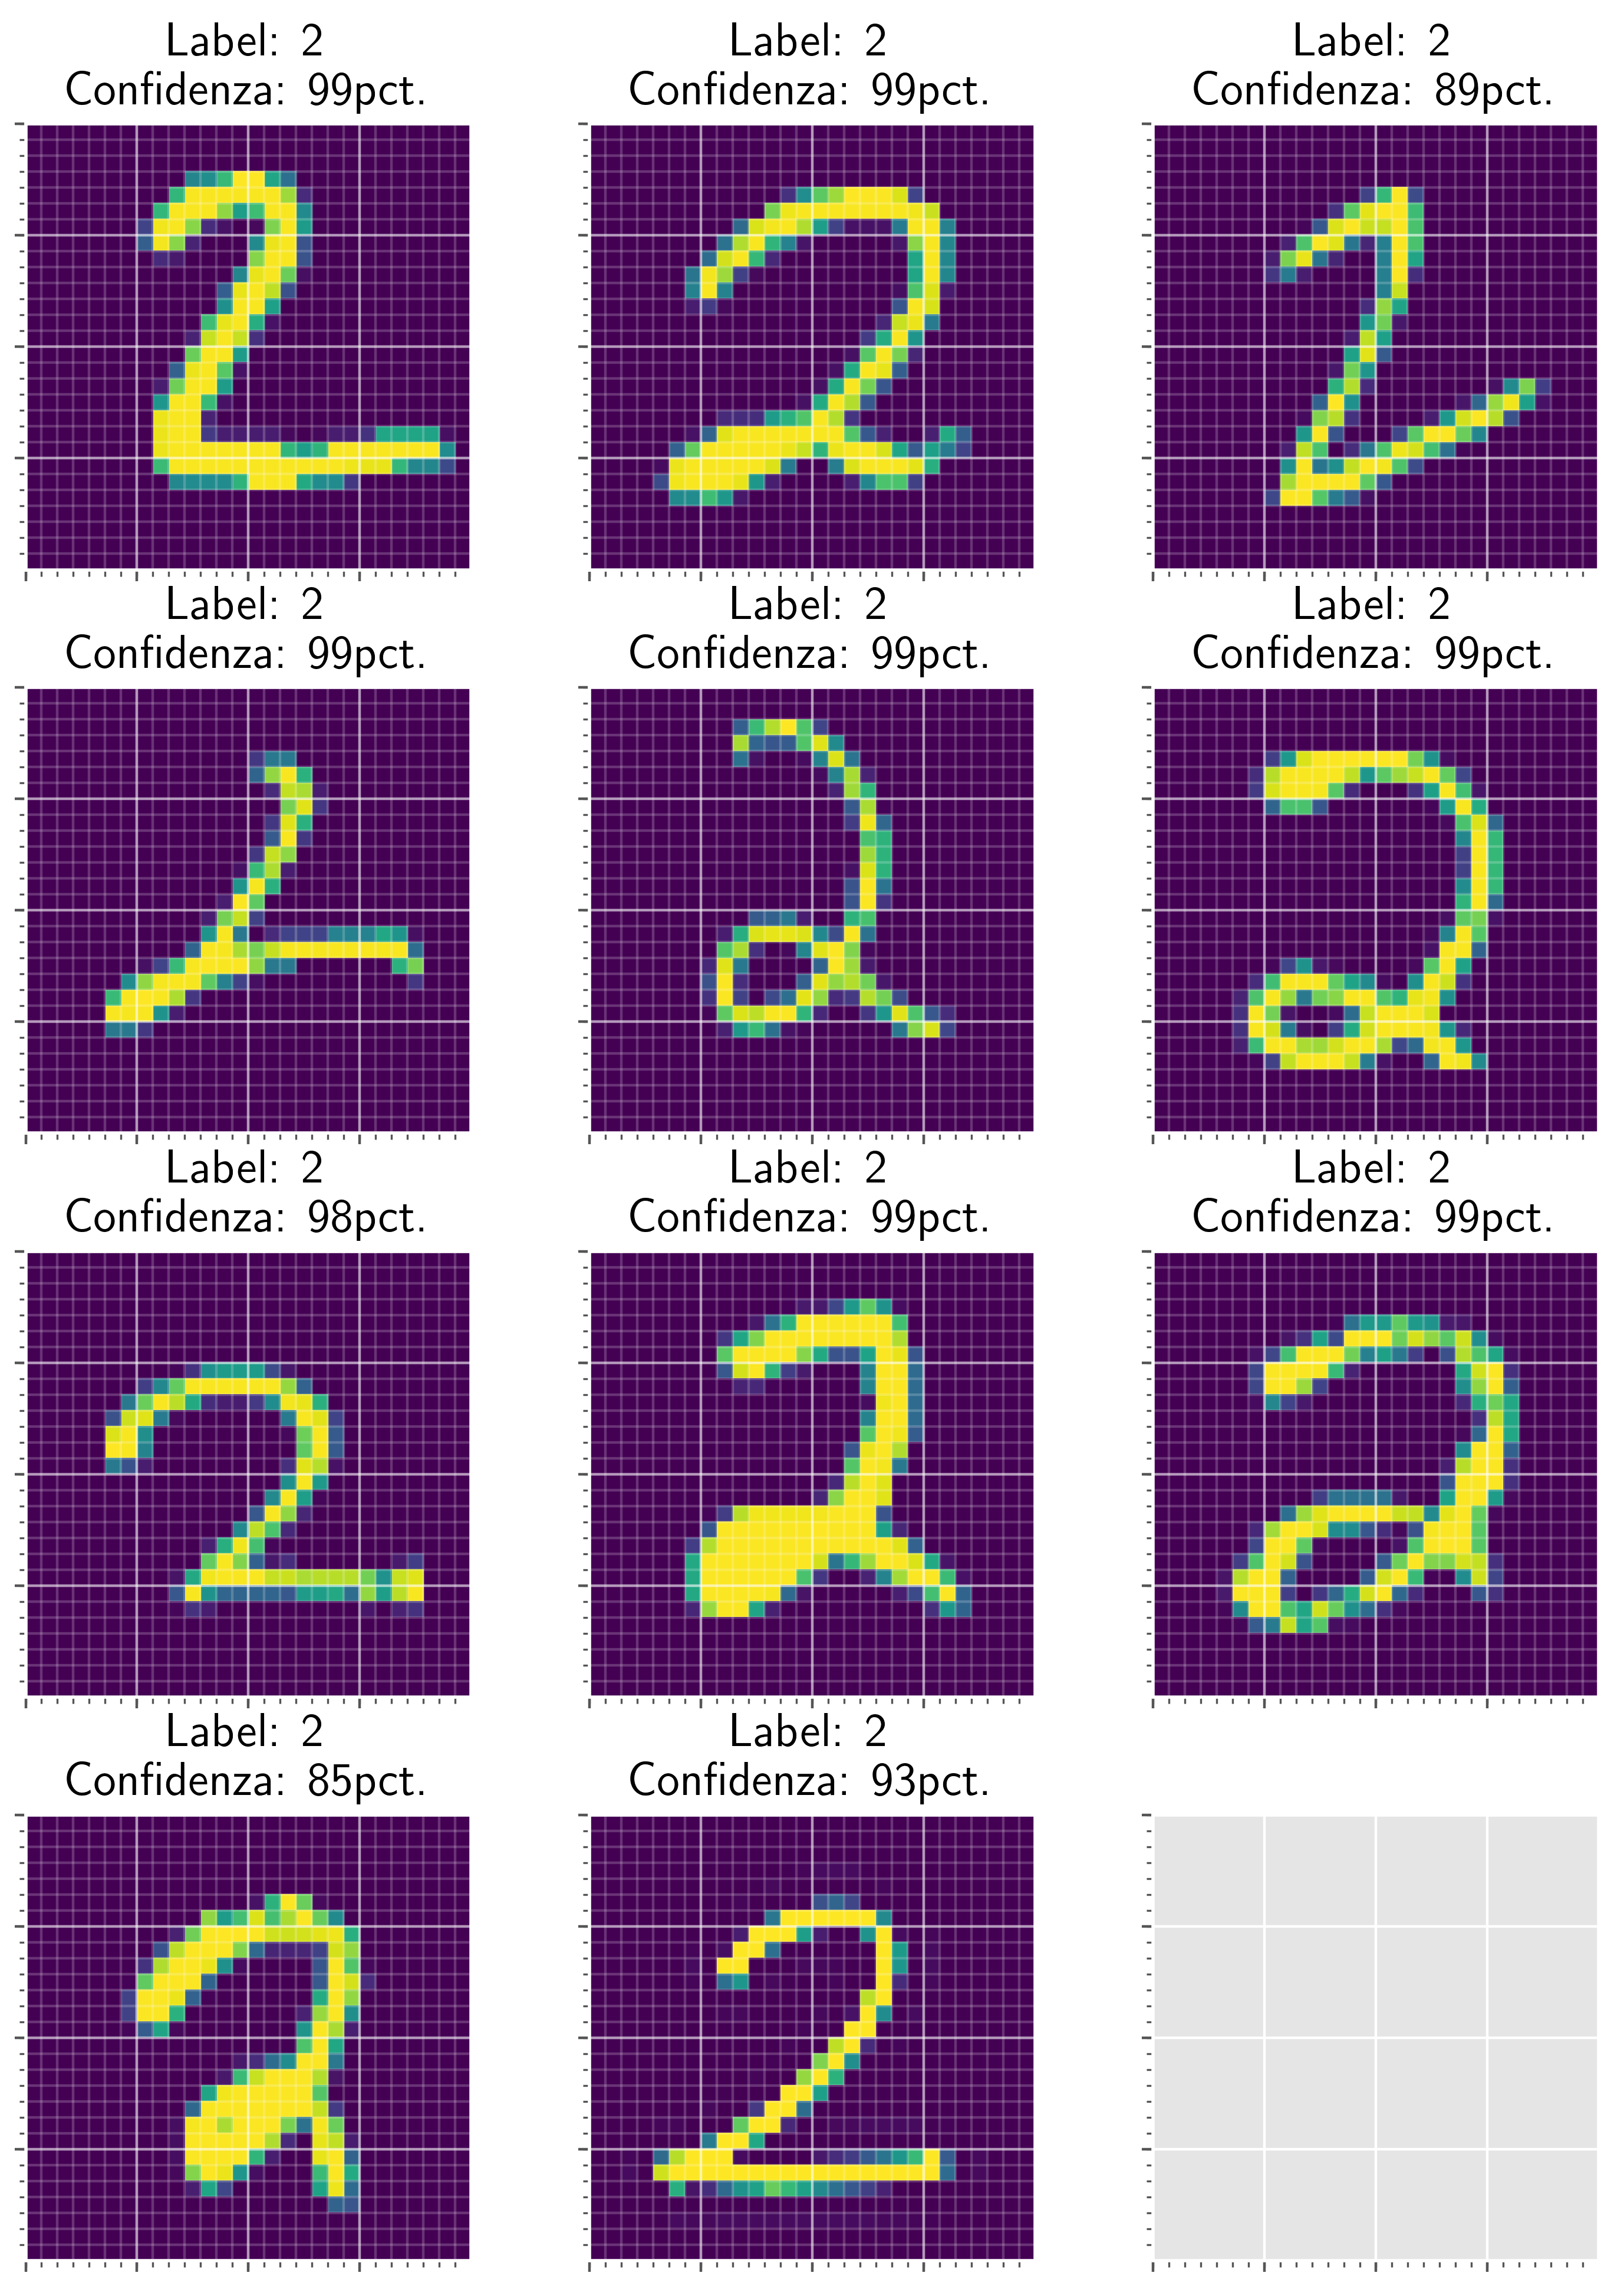

In [20]:
pixels_handwritten = np.array(imageprepare(handwritten_number))
x_batch = np.append(x_batch, [pixels_handwritten],axis=0)
plot_predictions(x_batch)

Ora che abbiamo visto che il nostro modello funziona correttamente passiamo all'implementazione del metodo FGSM in versione iterativa:

### Implementazione: FGSM Iterativo

L'algoritmo da implementare è estremamente semplice: in primis dobbiamo procedere con l'assegnamento $ \hat{X} \leftarrow X $ e poi si ripeterà per un certo numero di step
1. $\hat{X} \leftarrow \hat{X} + \alpha \cdot \nabla \log P\left(\hat{y} \mid \hat{X}\right)$
2. $\hat{X} \leftarrow \text{Clip}_{X,\epsilon}(\hat{X}) $

$\alpha$ può essere deciso arbitrariamente:

Calcoliamo la funzione di costo: essa dovrà essere la stessa che abbiamo usato in fase di addestramento: `tf.nn.softmax_cross_entropy_with_logits()`, impostando come label di riferiemnto `y_label` che andremo a scegliere opportunamente.

Definiamo poi i gradienti della funzione di costo rispetto agli input: ricordiamo che stiamo linearizzando la funzione di probabilità quindi nel calcolo dell'immagine non consideriamo le derivate successive ma solo quelle parziali, per fare questo utilizziamo la funzione `tf.stop_gradient()`. 

Definiamo poi l'operazione di clipping dell'immagine e iteriamo le operazioni così definite sul numero di step che ci siamo prefissati di fare, organizziamo i risultati in un array di immagini su cui andiamo poi a chiamare `plot_predictions()`.

In [21]:
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    #Calcolo la funzione di costo,
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # clipping
    
    for _ in range(n_steps):
        # Calcolo dei gradienti e dell'immagine modificata
        dydx = mnistsess.run(deriv, {x: x_image, keep_prob: 1.0}) 
        x_adv = mnistsess.run(image_adv, {x: x_image, keep_prob: 1.0})
        
        # Aggiungiamo l'immagine dei gradienti e l'immagine avversariale a img_adv_list
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Output
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step

Proviamo a prendere ora un'immagine ( che può essere quella che abbiamo inserito, o una casuale tra le prime 1000 immagini del test set ) ed una label di riferimento da inserire come argomento nel calcolo del gradiente.

In [22]:
take_userpic = True

if (take_userpic == True):
    image_norm = x_batch[-1]
else:    
    index_of_2s = np.nonzero(mnist.test.labels[0:1000][:,2])[0]
    rand_index = np.random.randint(0, len(index_of_2s))
    image_norm = mnist.test.images[index_of_2s[rand_index]]
    
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,1,0,0,0] # label cifra 6

Eseguiamo `create_plot_adversarial_images()` sull'immagine e la label scelte, con un numero di step pari a 6 ed un rate di apprendimento $\alpha$ pari a 0.35.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



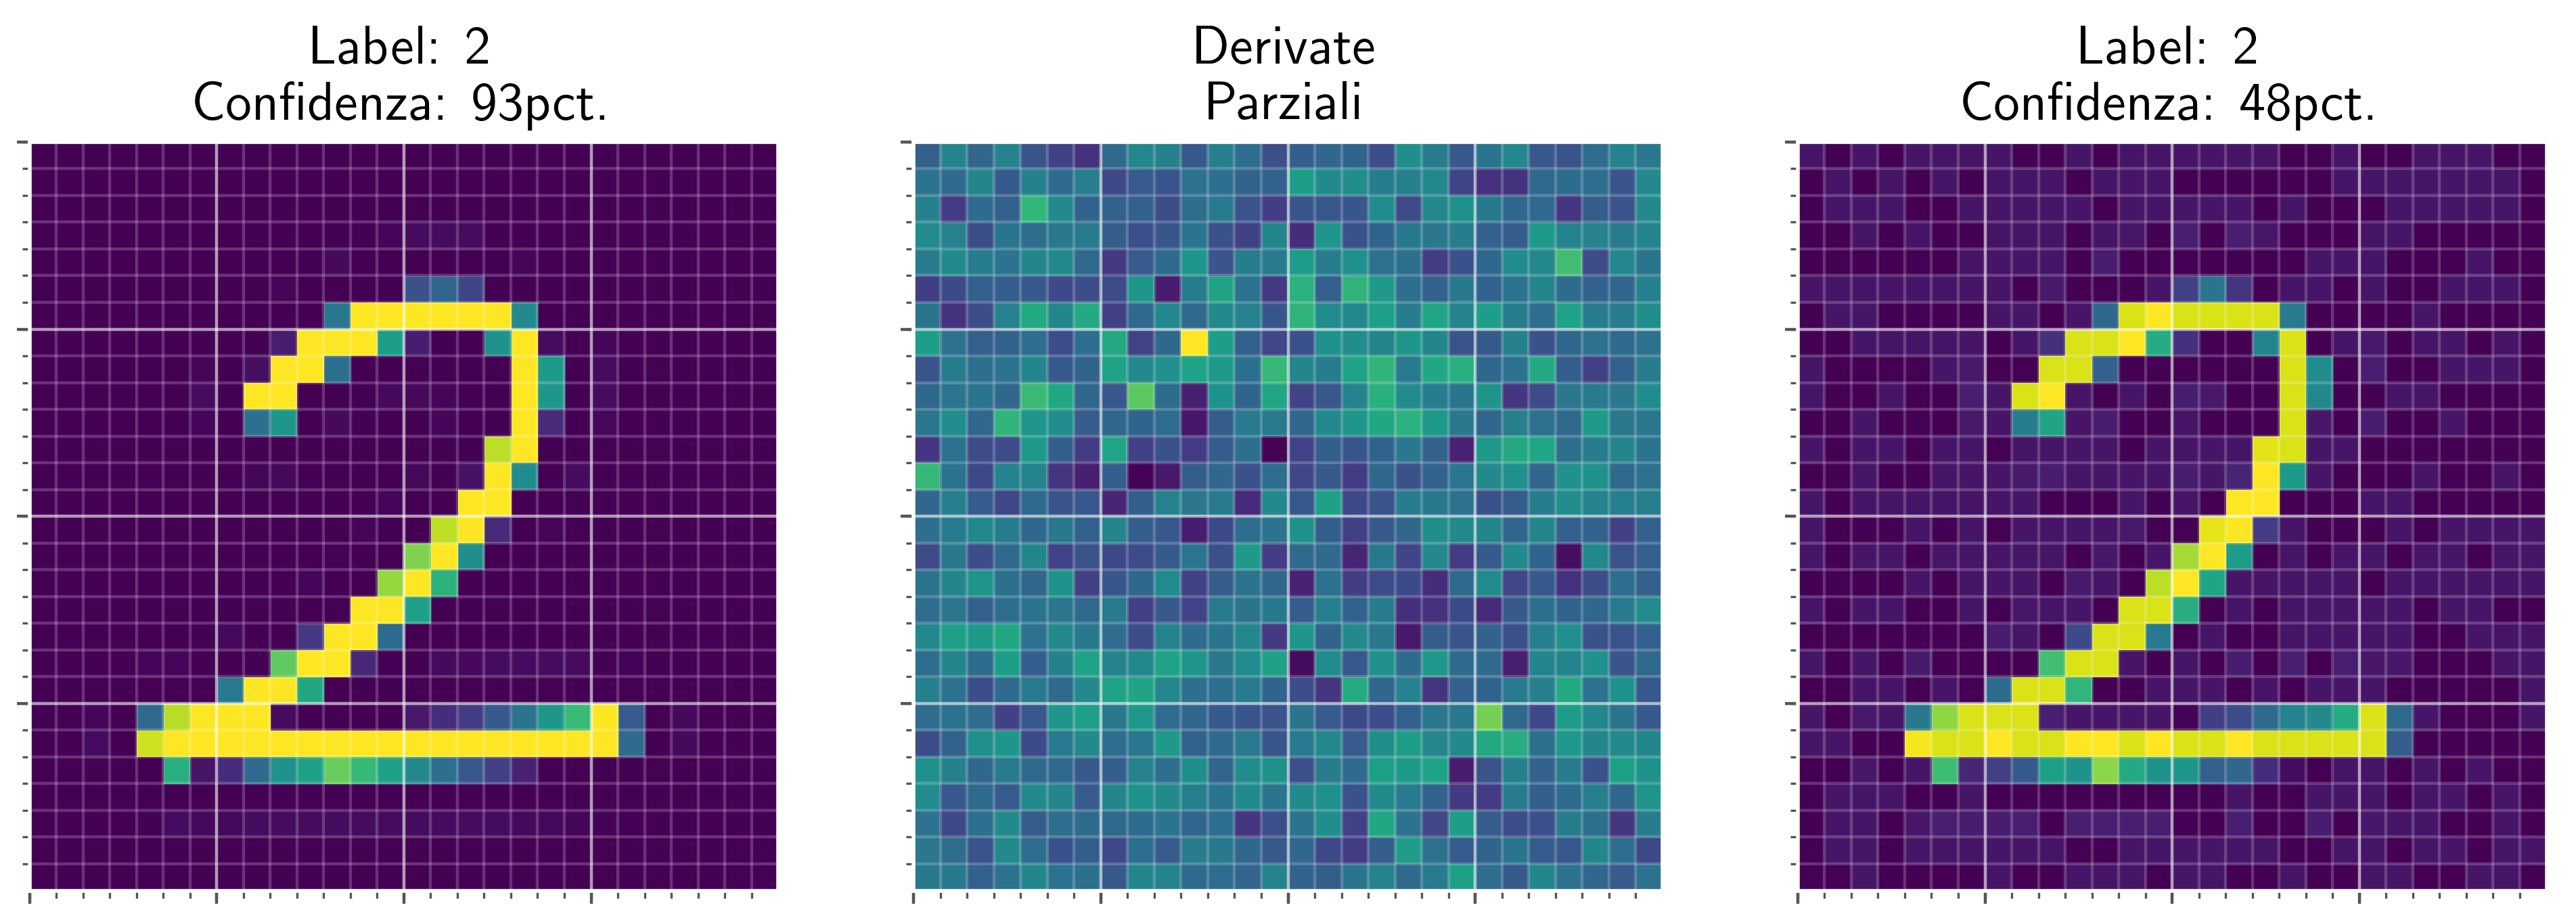

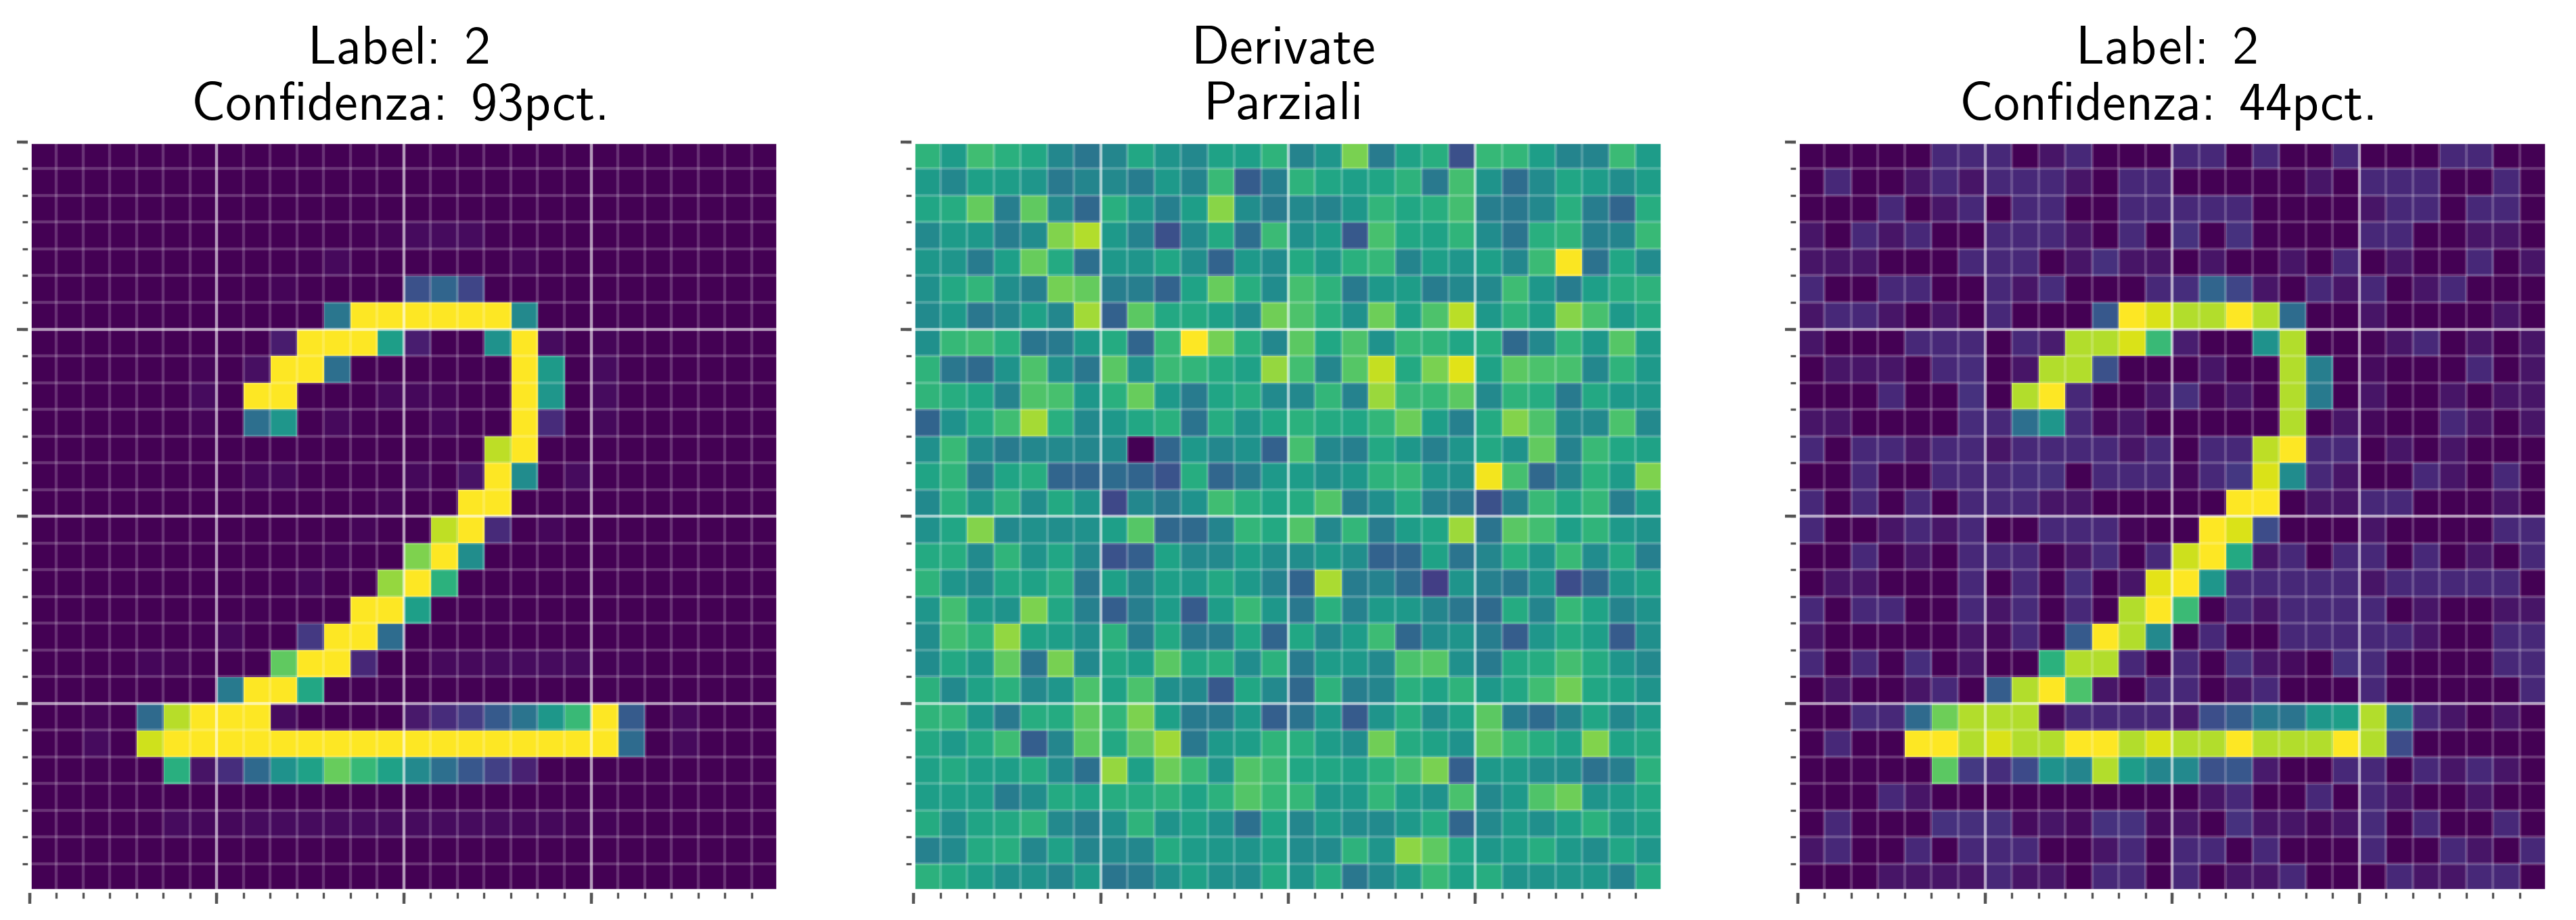

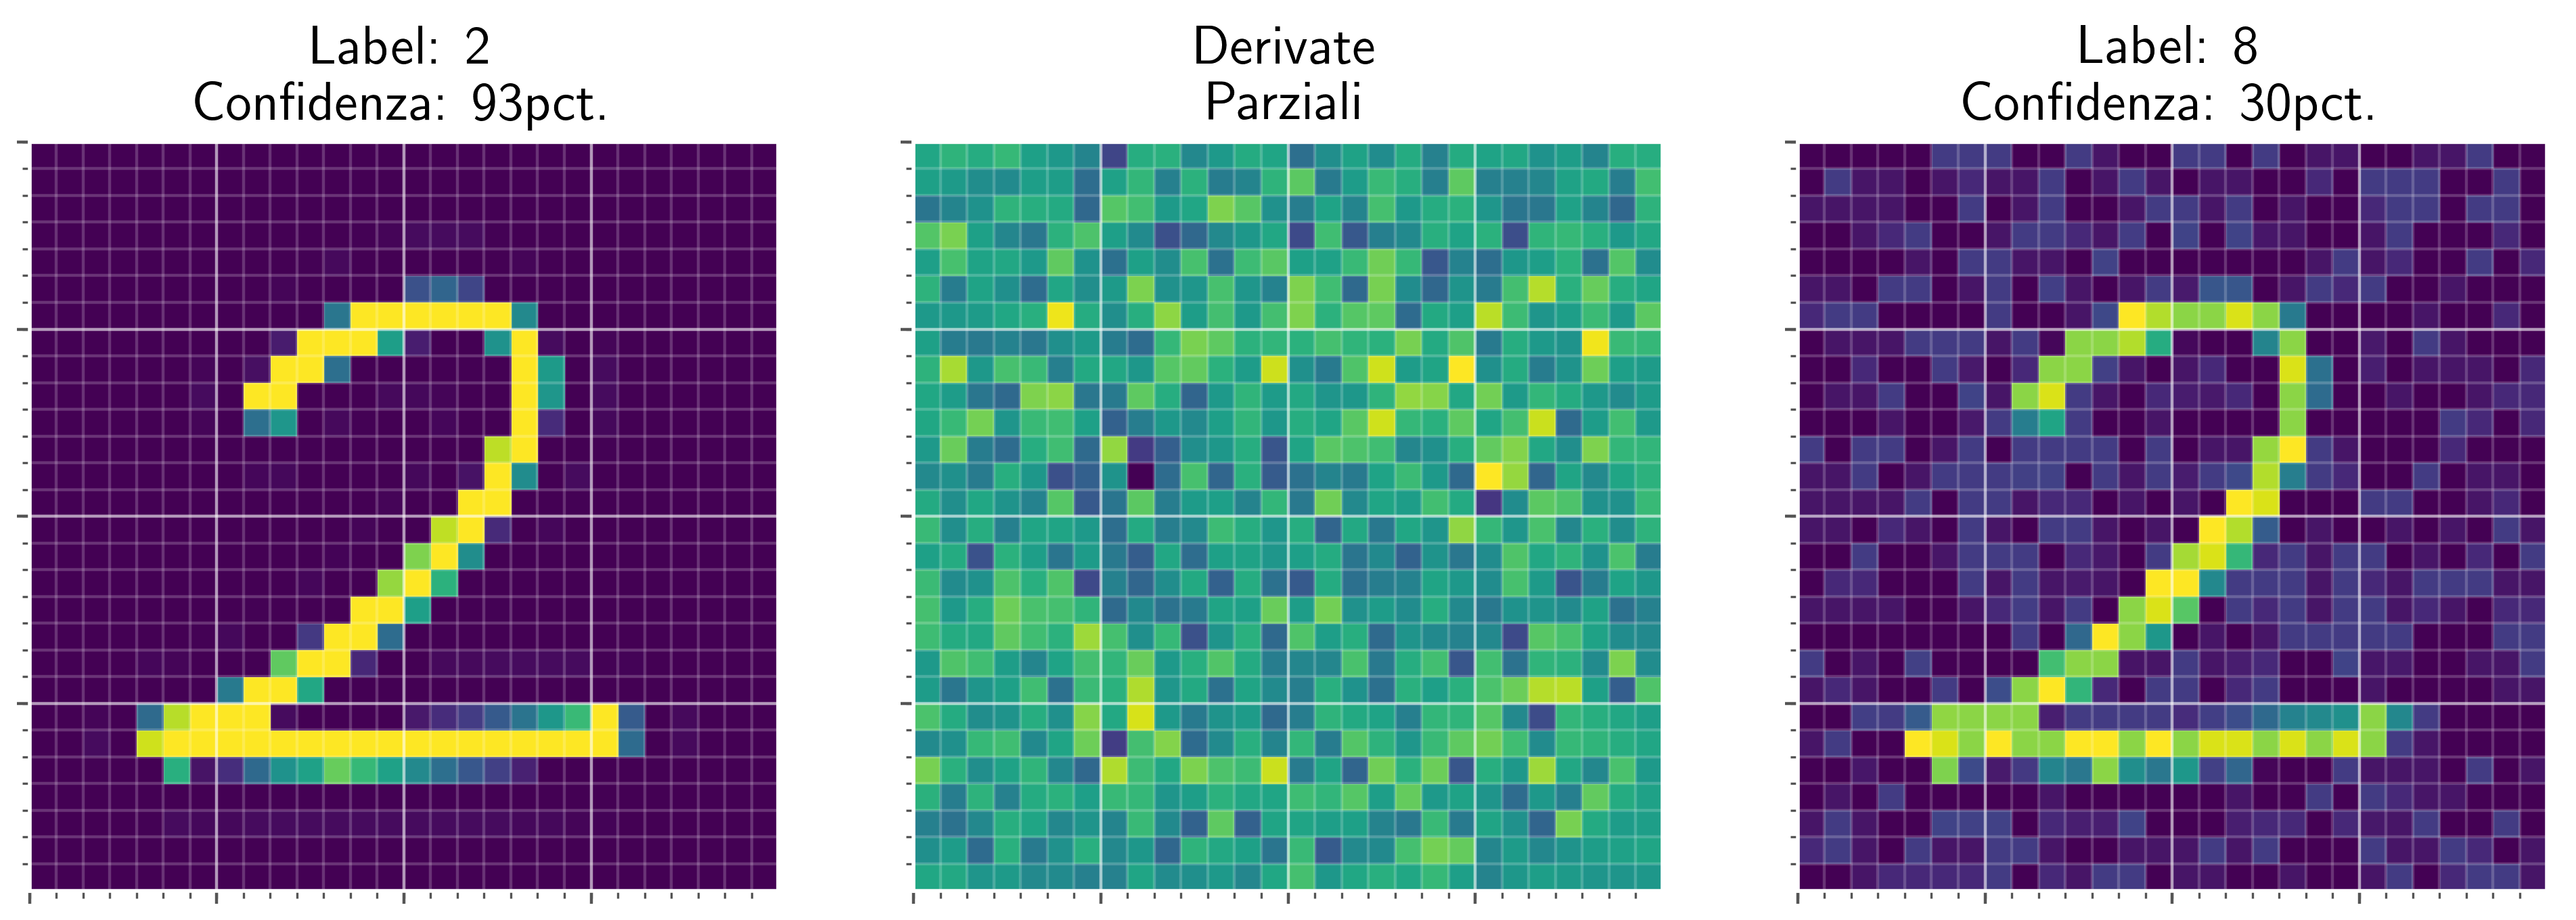

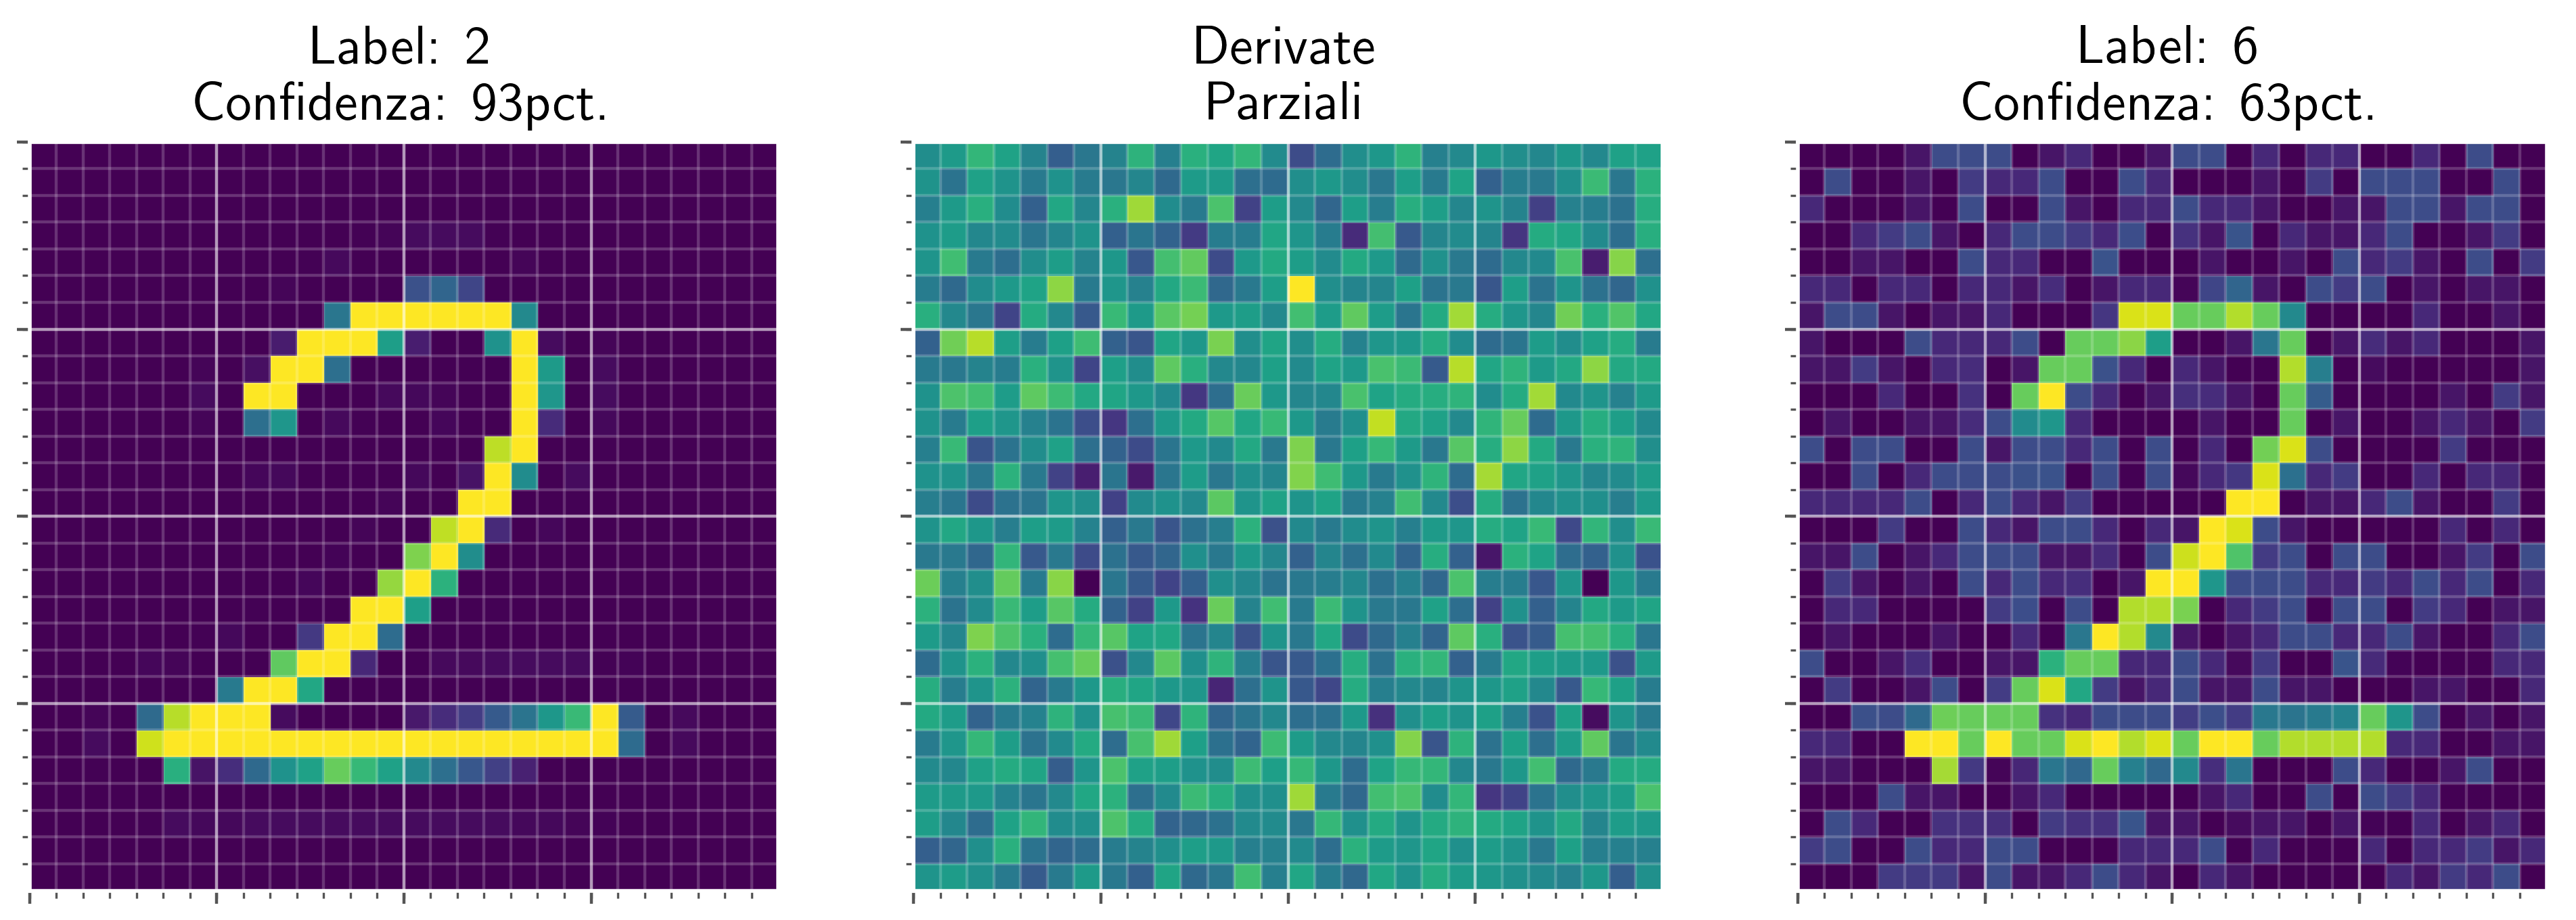

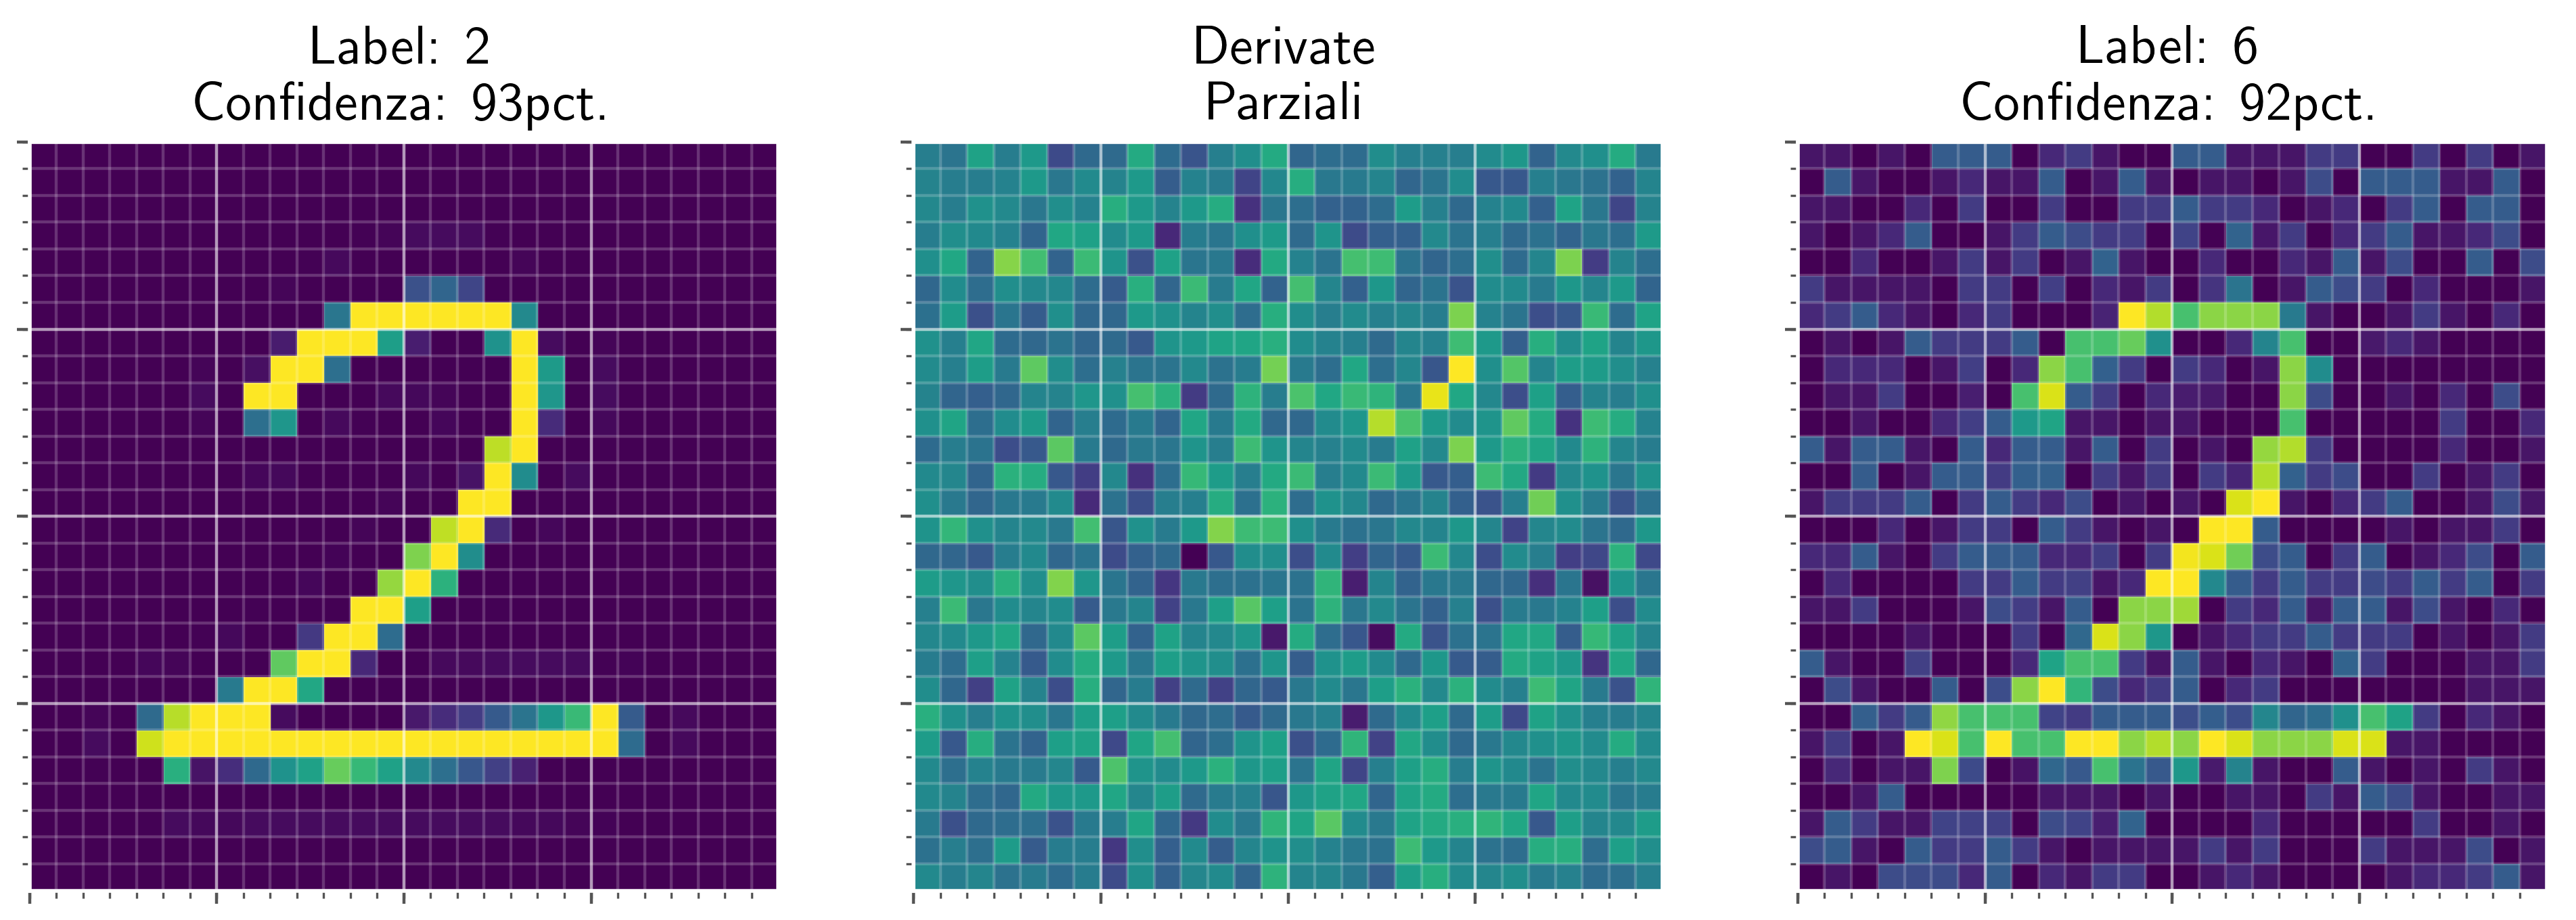

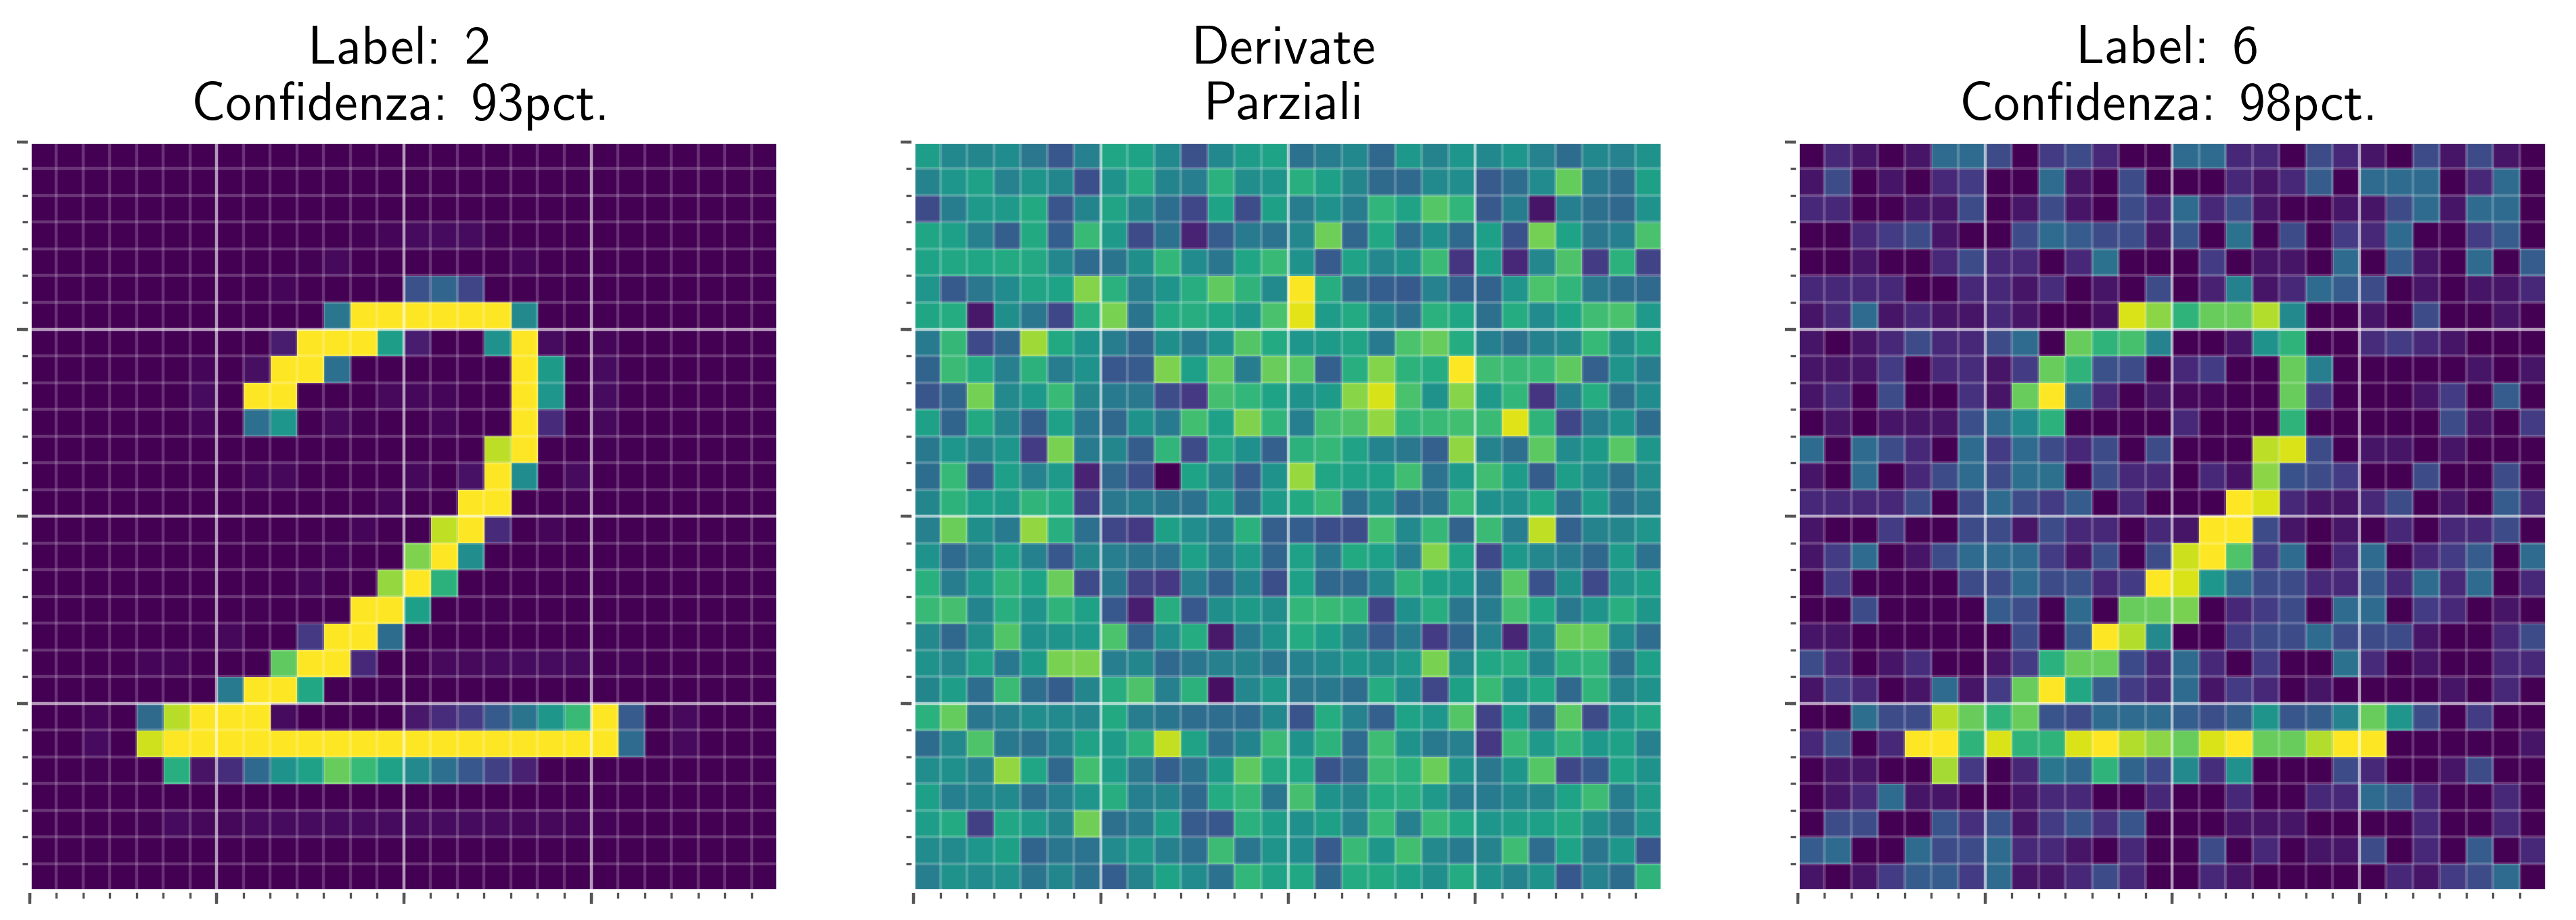

In [23]:
_ = create_plot_adversarial_images(image_norm, label_adv, lr=0.35, n_steps=6)

L'immagine all'aumentare del numero di step aumenta il proprio rumore, pur rimanendo simile ad un "2", ad occhio umano, ma viene  classificata come un "6" con confidenza crescente. Si può dire che l'attacco ha portato i risultati previsti.

In [24]:
mnistsess.close()

## Attacco a Google InceptionV3
Per dimostrare che la metodologia, non solo è applicabile anche a reti molto più complesse di quella presentata, ma che dovrebbe ottenere risultati più impressionanti con lo scalare della dimensionalità degli input (le immagini 28x28 di MNIST tendono ad essere piccole per i nostri scopi: il rumore avversariale è chiaramente visibile ad un umano che voglia controllare gli input), allora proviamo a spostarci su una piattaforma a dimensionalità maggiore: **_InceptionV3_**.


[**Inception v3**](https://arxiv.org/abs/1512.00567) è una delle reti più largamente utilizzate e liberamente scaricabile dalla [repository GitHub ufficiale di TensorFlow](https://github.com/tensorflow/models/tree/master/research/slim/nets), essa è addestrata sul dataset [**ImageNet1000**](http://www.image-net.org/), uno dei più grandi e completi dataset disponibili online che distingue tra 1000 classi diverse. 

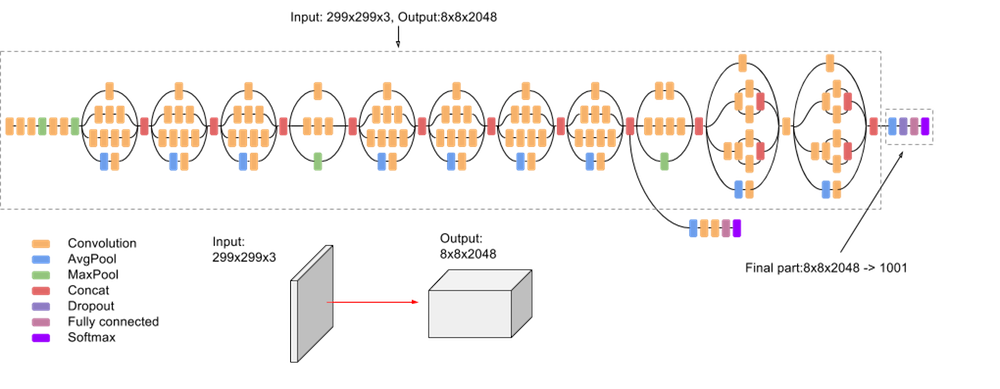

In [25]:
img_path, _ = urlretrieve('https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png')
PIL.Image.open(img_path)

La sua architettura è composta di moduli che comprendono strati di convoluzione, average-pooling, max-pooling e concatenazione; la parte finale della rete, che permette la distinzione tra 1001 classi diverse, è composta da uno strato dropout, uno completamente connesso ed infine uno strato softmax. L'addestramento di una rete di questo tipo è molto intensivo dal punto di vista computazionale ed è generalmente realizzato su hardware specializzato.

### Setup:

Iniziamo importando [`tensorflow`](https://github.com/tensorflow/tensorflow) e le librerie [`tf.contrib.slim`](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim), che contengono il modello `inception_v3` ed inizializziamo una sessione.

In [26]:
import tensorflow as tf

import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

Inizializziamo l'immagine di input come una `tf.Variable` invece che come una `tf.placeholder` perchè avremo bisogno di aggiornare dinamicamente la stessa per generare un _adversarial example_.
La rete accetta nativamente immagini RGB 299x299: immagini di dimensioni differenti andranno opportunamente ridimensionate.

In [27]:
image = tf.Variable(tf.zeros((299,299,3)))

Definiamo a questo punto la struttura della rete usando [`slim/nets/inception_v3.py`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/inception_v3.py), nei commenti del file originale sono disponibili tutte le descrizioni degli argomenti delle funzioni `inception_v3()` ed `inception_v3_arg_scope()`.

In [28]:
def inception(image, reuse):
    #l'immagine viene pre-processata per essere passata a inception_v3
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        # ottengo le stime in formato logit da inception_v3()
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignoro classe background, 1000 classi totali
        probs = tf.nn.softmax(logits) # calcolo probabilità usando softmax
    return logits, probs

logits, probs = inception(image, reuse=False)

da notare che `inception_v3()` restituisce le probabilità in formato *logits* non normalizzato, con valori possibili compresi tra $ - \infty $ e $ + \infty $ , le probabilità vengono normalizzate poi con la funzione *SoftMax* che fornisce valori tra 0 ed 1.

La rete *Inception V3* può essere addestrata localmente, operazione computazionalmente molto costosa, oppure si possono utilizzare valori pre-addestrati dei pesi sinaptici: 

In [39]:
import tempfile
import tarfile
import progressbar


pbar = None
def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

scarichiamo i pesi sinaptici, il file pesa circa 100 Mb

In [40]:
data_dir = tempfile.mkdtemp()

#inception_tarball, _ = urlretrieve(
    #'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz',_,show_progress)
    
#tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

# se il file è già stato scaricato possiamo aprirlo direttamente
tarfile.open("inception_v3_2016_08_28.tar.gz", 'r:gz').extractall(data_dir)

impostiamo il `Saver()` di TensorFlow in modo che vengano caricati i pesi sinaptici appena recuperati

In [41]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

Proviamo a scaricare un'immagine dal web, eseguire la sua classificazione tramite InceptionV3 e visualizzare i risultati, anzitutto scarichiamo dal sito di A. Athalye una lista delle classi di ImageNet1000:

In [42]:
import json
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

definiamo una funzione `classify()` che avvii il calcolo della risposta di Inception_v3, grafichi l'immagine e le probabilità associate alle cinque classi più probabili, distinguendo se il riconoscimento da parte della rete è corretto o meno.

In [43]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),dpi=200)
    fig.sca(ax1)
    
    ax1.grid(False)

    p = sess.run(probs, feed_dict={image: img})[0] #calcolo probabilità
    ax1.imshow(img)
    fig.sca(ax1)
    topk = list(p.argsort()[-10:][::-1]) #selezione top-10
    topprobs = p[topk]
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
        
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
        
    prob0 = "{0:.2f}".format(topprobs[0])
    if correct_class == topk[0]:
        
        plt.title("Classificato come: {}, prob {}".format(imagenet_labels[topk[0]][:15],prob0))
    else:   
        plt.title("Classificato erroneamente come: {}, prob {}".format(imagenet_labels[topk[0]][:15],prob0))
        
    plt.sca(ax2)
    plt.title("Top 10")
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()
    
    return [topk, topprobs]

scarichiamo un'immagine da passare al classificatore, definiamone la classe e ridimensioniamola.

In [44]:
#gatto
#img_path, _ = urlretrieve('https://www.cats.org.uk/uploads/images/featurebox_sidebar_kids/grief-and-loss.jpg')
#panda rosso
img_path, _ = urlretrieve('https://i.ytimg.com/vi/b6dT4kyVUuY/maxresdefault.jpg')
#img_class = 281 #la classe corretta è '281: cat'
img_class = 387 #la classe corretta è '387: lesser panda, red panda'
img = PIL.Image.open(img_path)

big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)

#ridimensionamento immagine
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
#normalizzazione profondità colore
img = (np.asarray(img) / 255.0).astype(np.float32)

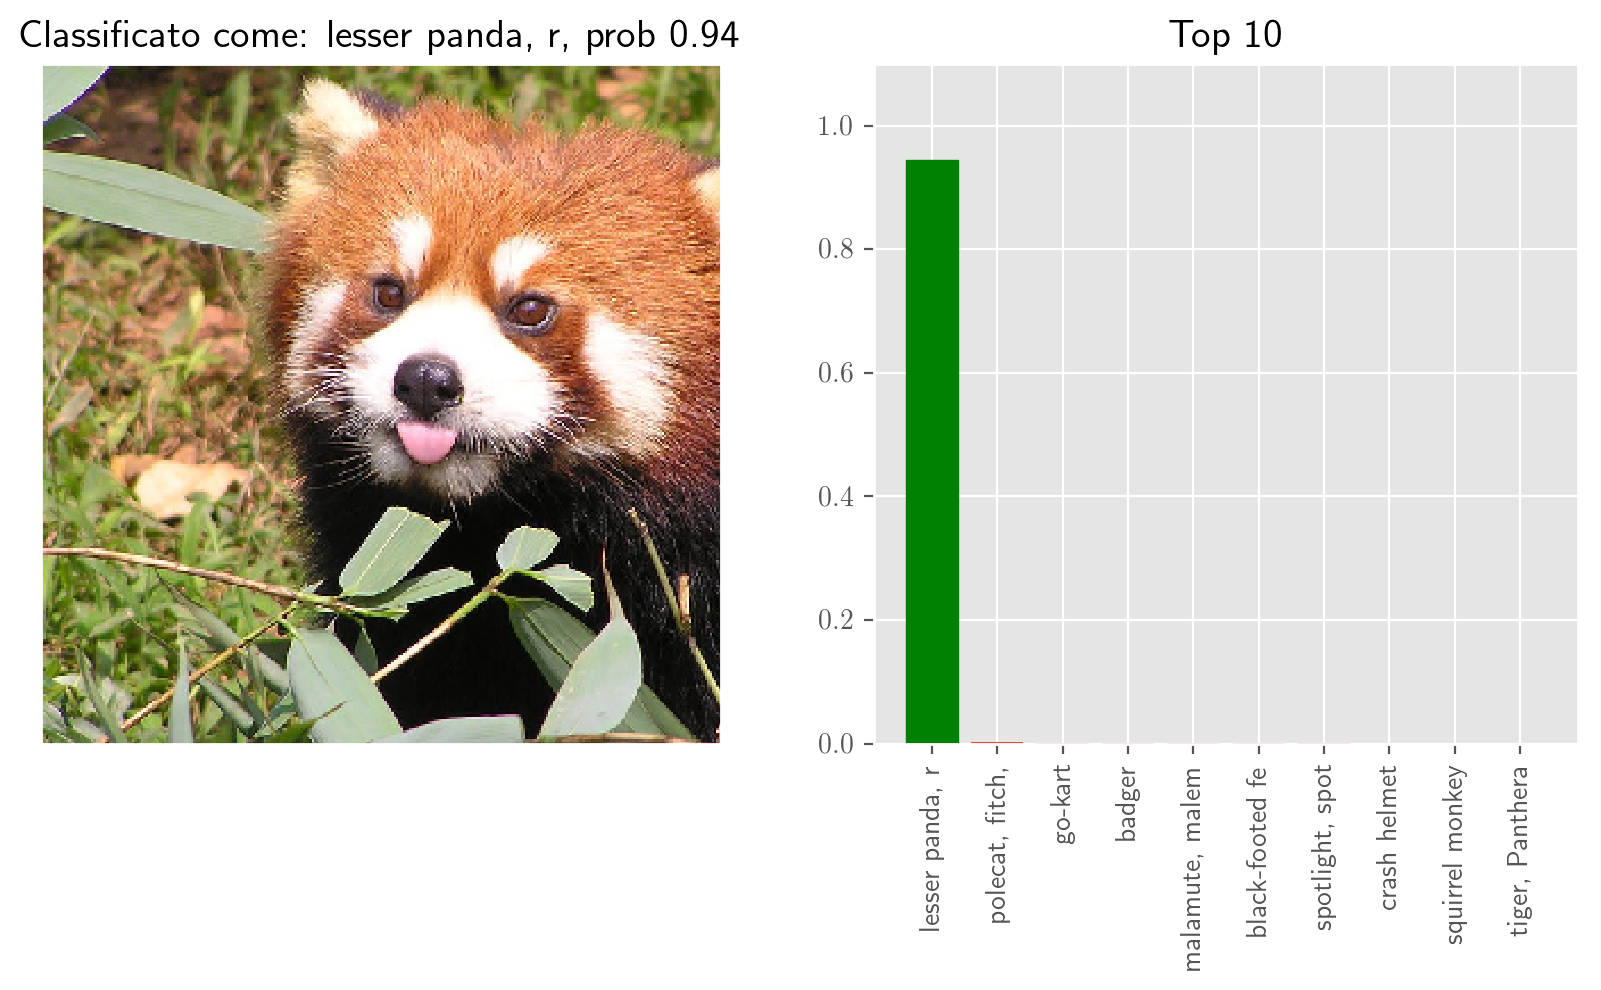

In [45]:
original_k =  classify(img, correct_class=img_class)

Il bin *lesser panda* di colore verde indica che la predizione di Inception_V3 è giusta.

### Implementazione FSGM Iterativo:

Cominciamo col primo tra i metodi iterativi presentati, l'algoritmo, esattamente come nel caso del classificatore MNIST, è semplice: ancora una volta il primo step sarà l'assegnamento $ \hat{X} \leftarrow X $, poi si ripeterà fino a convergenza la sequenza
1. $\hat{X} \leftarrow \hat{X} + \alpha \cdot \nabla \log P\left(\hat{y} \mid \hat{X}\right)$
2. $\hat{X} \leftarrow \text{Clip}_{X,\epsilon}(\hat{X}) $



In [46]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image 
assign_op = tf.assign(x_hat, x)

impostiamo dei placeholder per il rate di apprendimento $ \alpha $ e per $ \hat{y} $, stabiliamo che le label sono in formato _one-hot_ di lunghezza 1000 ed impostiamo il calcolo della funzione di costo _cross-entropy_. Impostiamo anche l'ottimizzatore a _gradient-descent_ che minimizzerà `loss` modificando l'immagine `x_hat` con un learning rate pari a `learning_rate`.

In [47]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

Impostiamo un placeholder per $ \epsilon $ e definiamo l'operazione di clipping tra due estremi in modo tale per mantenere l'immagine generata in un intorno di $\epsilon$ da $X$.

In [48]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

Passiamo all'avvio del calcolo vero e proprio: impostiamo un valore iniziale per $ \epsilon, \alpha $, il numero di step che vogliamo effettuare e la classe che vogliamo miscalssificare.

In [49]:
demo_epsilon = 2.0/255.0 # 2 livelli su 255
demo_lr = 1e-1
demo_steps = 100
demo_target = 742 # "printer"

In [50]:
# step inizializzazione
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    #  clip
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))

adv_saver = tf.train.Saver({"x_hat": x_hat}) 
save_path = adv_saver.save(sess, './naive_adv.ckpt')
adv = x_hat.eval()

step 10, loss=0.00487757
step 20, loss=0.00272986
step 30, loss=0.00201428
step 40, loss=0.00162719
step 50, loss=0.00137949
step 60, loss=0.00120543
step 70, loss=0.00107314
step 80, loss=0.000969893
step 90, loss=0.000887239
step 100, loss=0.000819586


L'immagine avversariale non risulta visivamente diversa dall'originale, anche se viene classificata [erroneamente](https://github.com/filippocastelli/Analisi_Immagini/blob/master/img/choices_to_make.png) dalla rete.

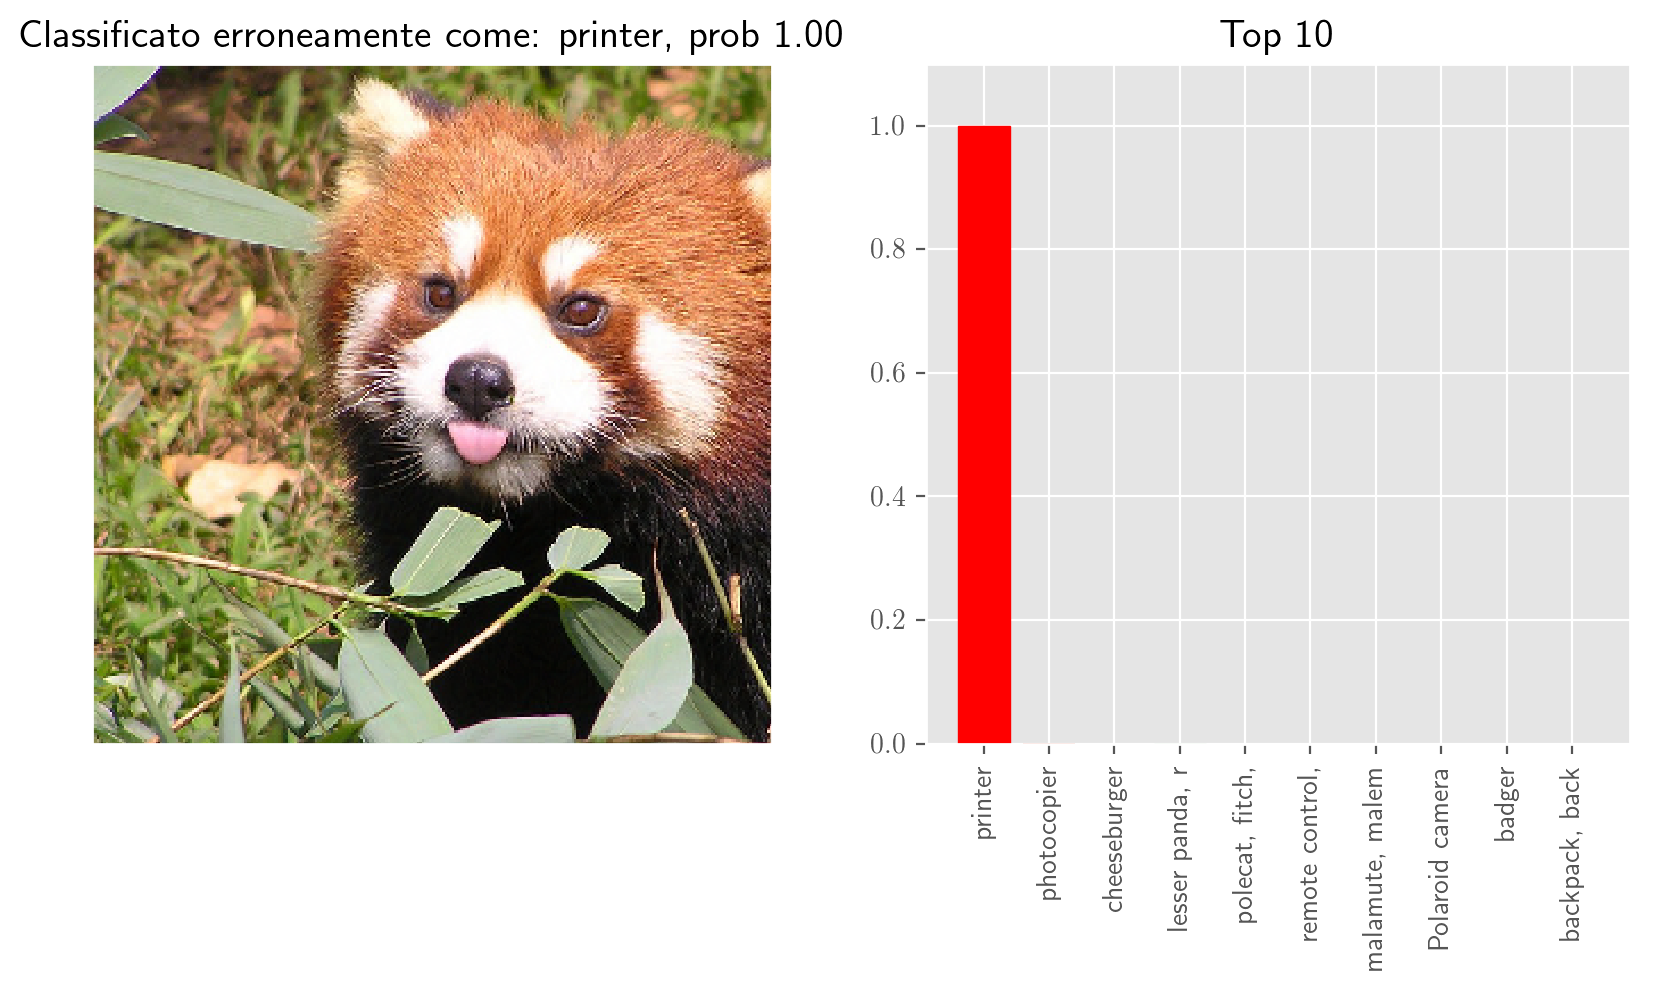

In [51]:
#possiamo recuperare da file l'immagine avversariale per non dover rifare il training
#adv_saver.restore(sess, './naive_adv.ckpt')
#adv = x_hat.eval()

adversarial_k = classify(adv, correct_class=img_class, target_class=demo_target)

Visualizziamo quindi l'immagine originale, il rumore avversariale e l'immagine generata:

In [52]:
def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    # Normalizziamo in modo che i valori dell'immagine siano compresi tra 0 e 1
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

def plot_images(image, adv, origk=0,advk=0):
    
    imgname = imagenet_labels[origk[0][0]][:15]
    classification = imagenet_labels[advk[0][0]][:15]
    imgprob = "{0:.2f}%".format(origk[1][0])
    advprob = "{0:.2f}%".format(advk[1][0])
    
    fig, axes = plt.subplots(1, 3, figsize=(10,10),dpi=200)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    smooth = True
    if smooth:
        #interpolazione spline16 divide l'intervallo in 16 parti e interpola con 16
        #polinomi diversi, con condizioni di raccordo lisce.
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    #plot immagine originale
    ax = axes.flat[0]
    ax.imshow(image , interpolation=interpolation)
    ax.set_xlabel("Immagine Originale\n Classificato come: {}, prob {}".format(imgname, imgprob))
    #plot immagine avversariale
    noise = image - adv
    ax = axes.flat[2]
    ax.imshow(adv, interpolation=interpolation) 
    ax.set_xlabel("Immagine + Rumore \n Classificato come: {}, prob {}".format(classification,advprob))
    #plot rumore
    ax = axes.flat[1]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Rumore Amplificato"
    ax.set_xlabel(xlabel)
    
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

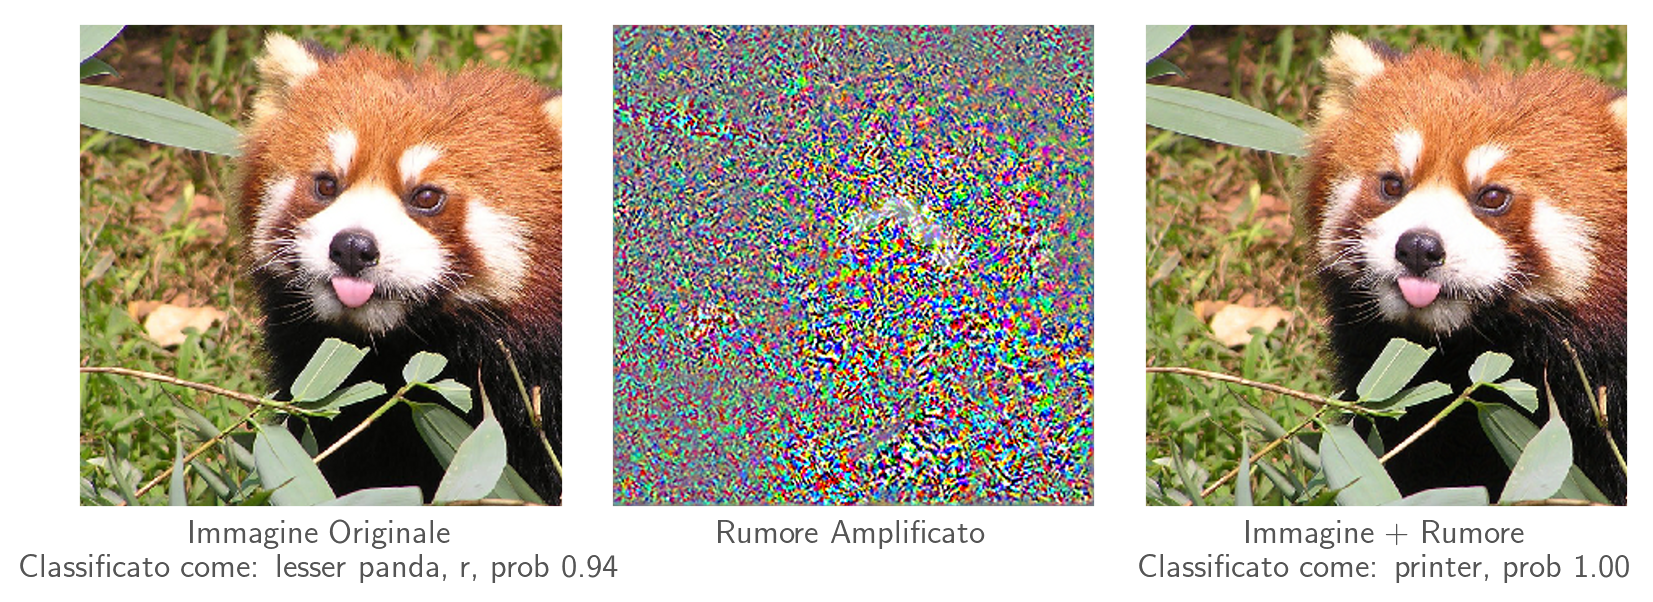

In [53]:
plot_images(img, adv, original_k, adversarial_k)

### Implementazione Expectation Over Transformation:

Vediamo subito come l'immagine avversariale così creata non rimane tale sotto trasformazioni, applichiamo prima una rotazione di $ \frac{\pi}{10} $, poi una traslazione di 10px e 10px y successivamente una trasformazione generica descritta ad un vettore di trasformazione `[a0, a1, a2, b0, b1, b2, c1, c2] = [1,0.1,-5,0.1,1,+5,0.0001,0.002]` con

$ \begin{equation} \begin{split}
x' = \frac{a_0 x + a_1 y + a_2}{k} \\
y = \frac{b_0 x + b_1 y + b_2}{k} \\
k = c_0 x + c_1 y +1
    \end{split}\end{equation}
    $

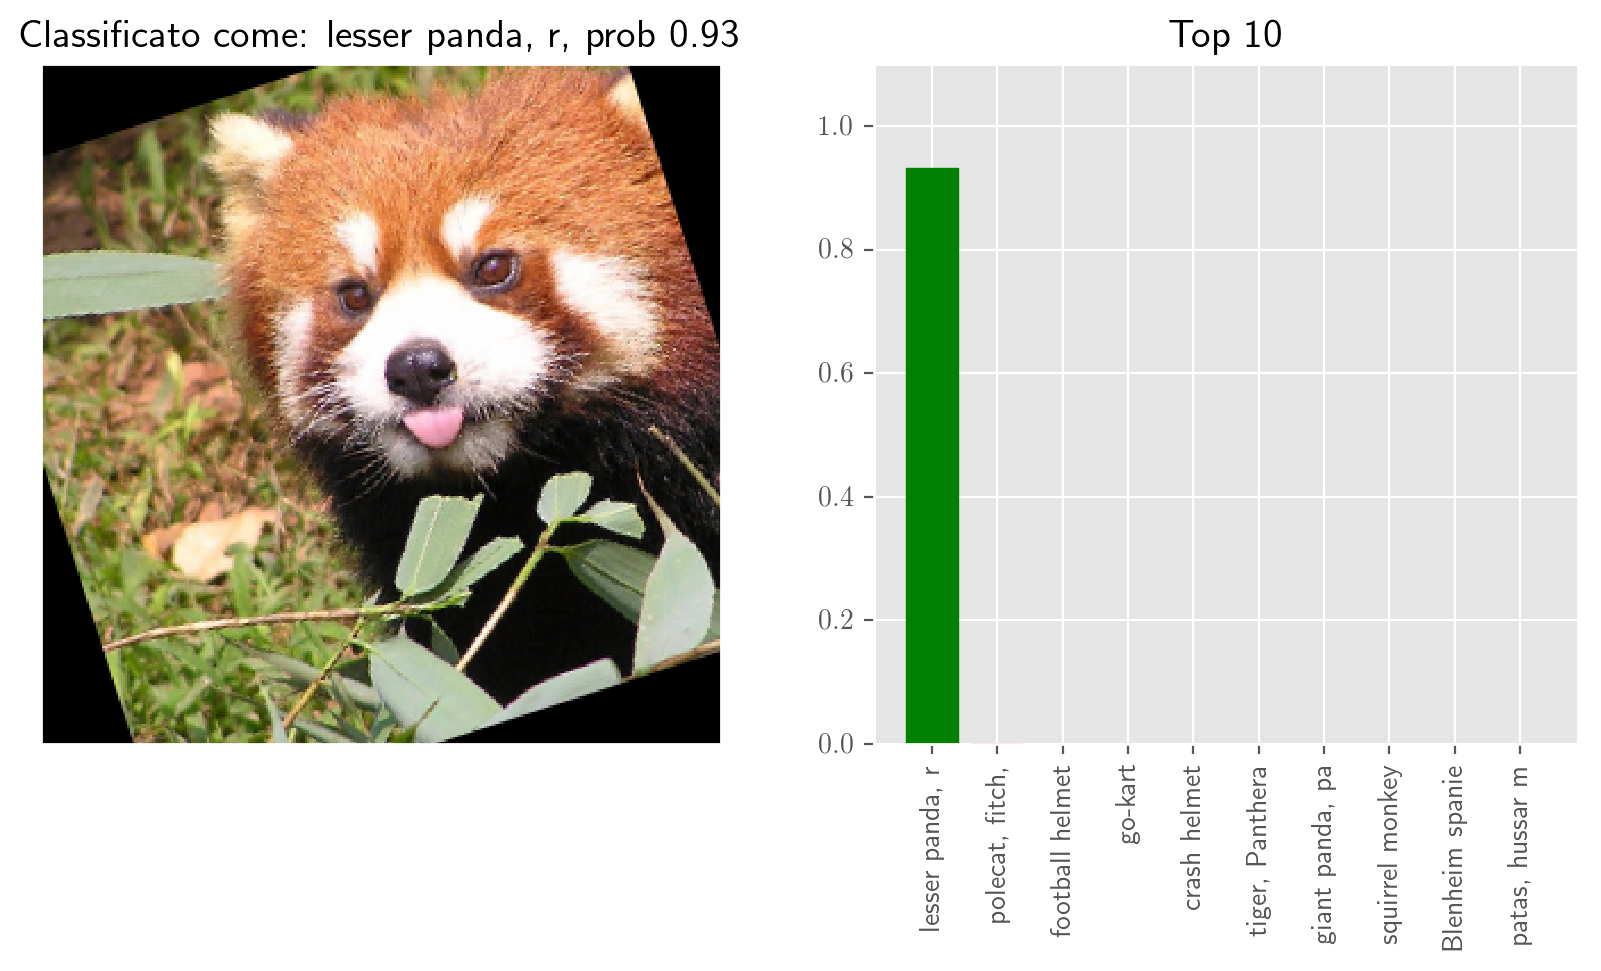

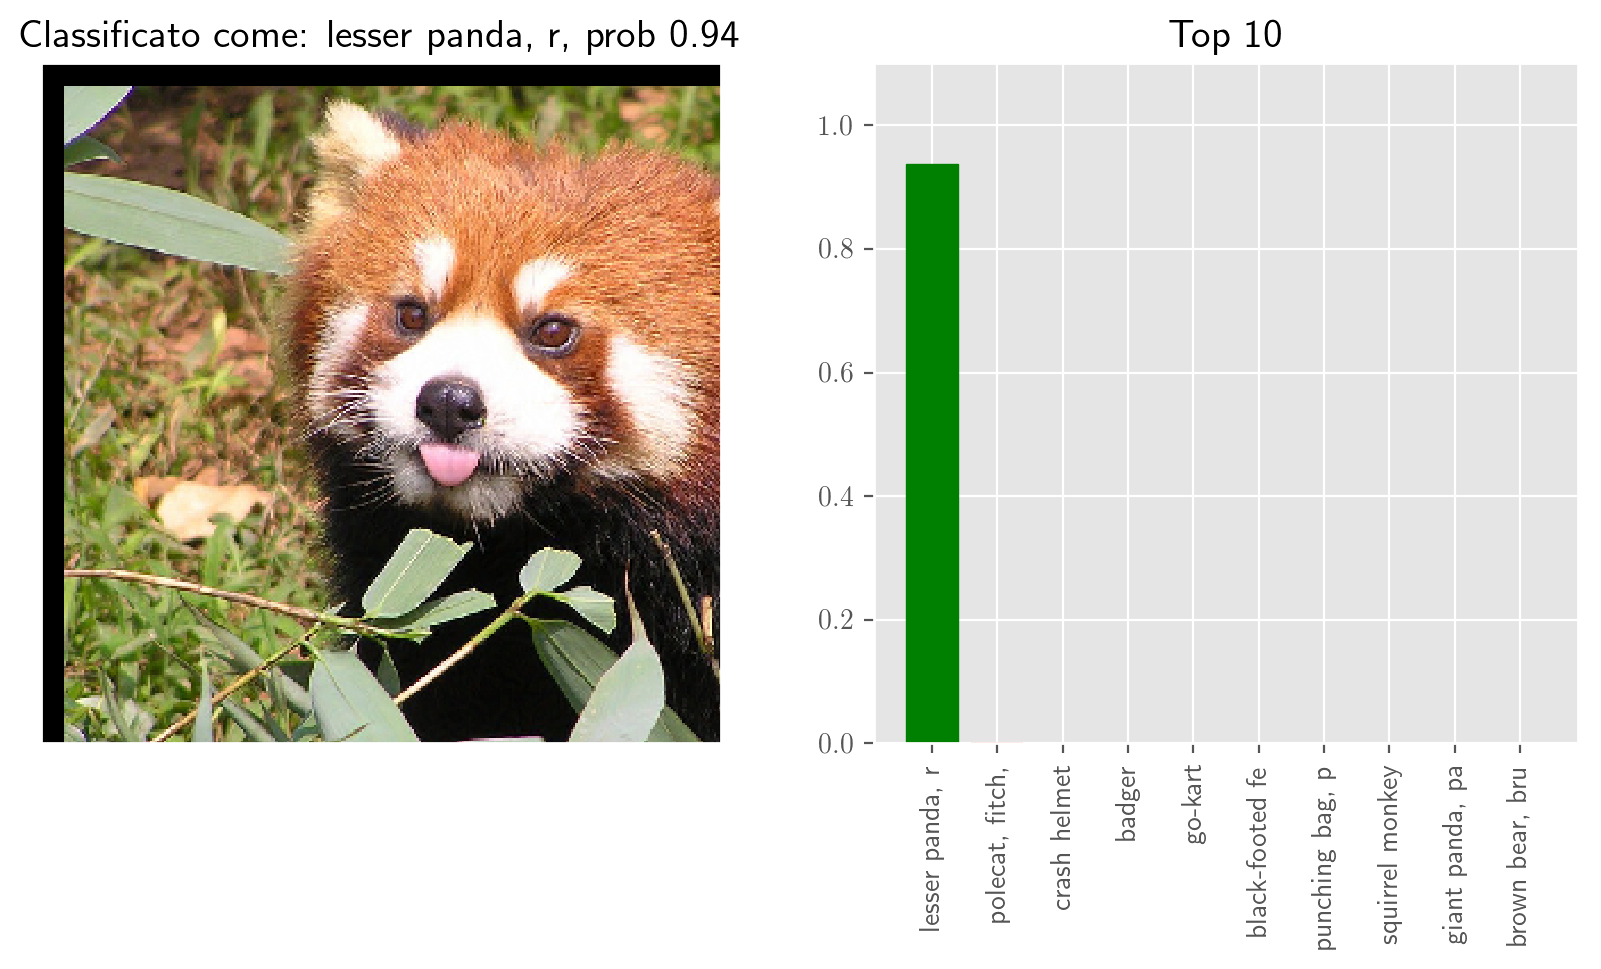

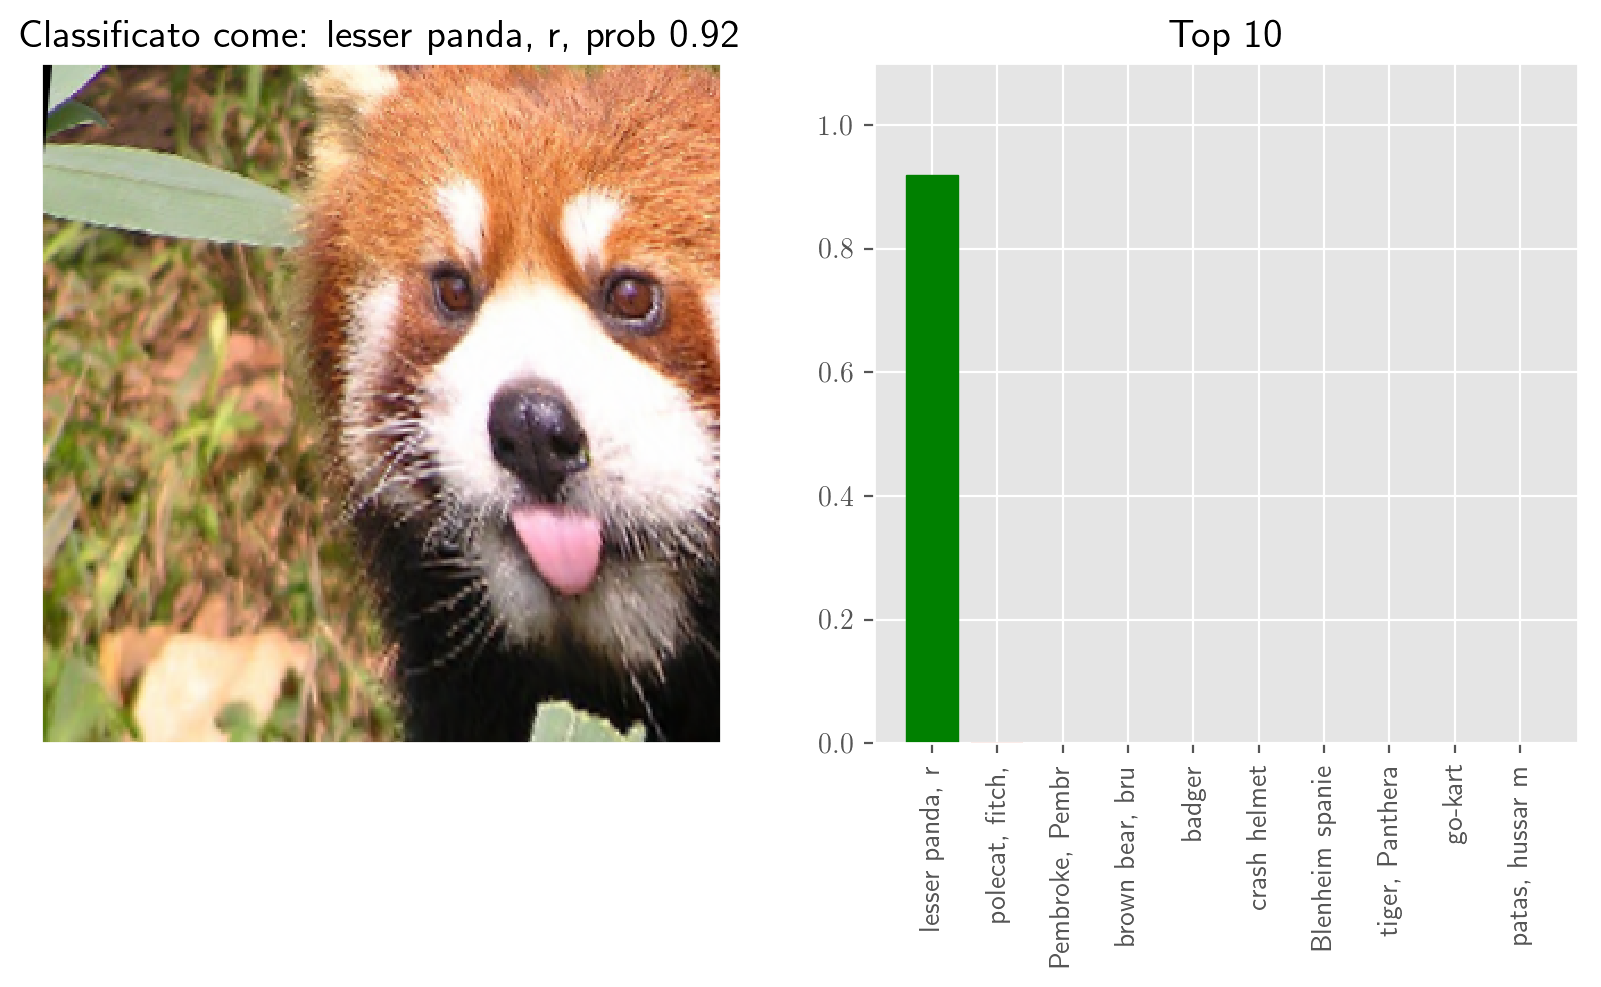

In [55]:
ex_angle = np.pi/10
angle = tf.placeholder(tf.float32, ())
#interpolazione bilineare per rotazione supportata in TensorFlow 1.7
rotated_image = tf.contrib.image.rotate(image, angle, "BILINEAR") 
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
_, _ = classify(rotated_example, correct_class=img_class, target_class=demo_target)

ex_translation = [10,10]
translation = tf.placeholder(tf.float32, (2))
translated_image = tf.contrib.image.translate(image, translation, "BILINEAR") 
translated_example= translated_image.eval(feed_dict={image: adv, translation: ex_translation})
_, _ = classify(translated_example, correct_class=img_class, target_class=demo_target)


              #[a0,a1,a2,b0,b1,b2,c0,c1]
ex_transform = [1,0.1,-5,0.1,1,+5,0.0001,0.002]
transforms = tf.placeholder(tf.float32, (8))
transformed_image = tf.contrib.image.transform(image, transforms, "BILINEAR") 
transformed_example = transformed_image.eval(feed_dict={image: adv, transforms: ex_transform})
_, _ = classify(transformed_example, correct_class=img_class, target_class=demo_target)

In tutti e tre i casi l'immagine perde le sue caratteristiche avversariali iniziali. 
Per superare questo problema utilizziamo l'algoritmo di _Expectation Over Transformation_, ovvero risolviamo il problema di massimizzazione di $\mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{X}})\right)$,  con vincolo $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$, notando che $\nabla \mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{X}})\right)$ è pari a $\mathbb{E}_{t \sim T} \nabla \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$.
A rigor di logica dovremmo definire un nuovo algoritmo di _gradient-descent_ che faccia sampling sulla disribuzione delle trasformazioni ma, per semplificare i calcoli, possiamo modellare l'operatore di _discesa del gradiente con sampling sulle trasformazioni_ come un normalissimo _gradient-descent_ effettuato però su un ensemble di classificatori che operino su un sampling uniforme della distribuzione e trasformino i propri input prima della classificazione.

Tale approssimazione può sembrare più artificiosa ed elaborata di quello che veramente è, proviamo ad implementarla:

Definiamo il numero di sample che vogliamo prendere dalla distribuzione delle trasformazioni lungo il gradient-descent come `num_samples` e facciamo un sampling dalla distribuzione campionando con probabilità uniforme al variare dei parametri le nostre trasformazioni e mediando i risultati:

In [56]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

in modo molto elegante possiamo sfruttare le capacità computazionali di TensorFlow per fare backpropagation al posto nostro e fare una classica _gradient-descent_ e minimizzare la `average_loss` agendo sui tensori `x_hat`.
Rispetto al caso precedente non abbiamo nessuna necessità di ridefinire nè `assign_op` ( $ \hat{X} \leftarrow X $ ) nè `project_step` ( $\hat{X} \leftarrow \text{Clip}_{X,\epsilon}(\hat{X}) $), ma dobbiamo modificare `optim_step` per fare la nostra _gradient-descent_ sull'ensemble: 

In [57]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

Definiti tutti i passaggi possiamo finalmente generare un'immagine avversariale:

In [59]:
demo_epsilon = 8.0/255.0 # 2 livelli su 255
demo_lr = 2e-1
demo_steps = 350
demo_target = 742 # "printer"

# primo step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # clip step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 35 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
        
adv_saver.save(sess, './robust_adv.ckpt',)
adv_robust = x_hat.eval() 

step 35, loss=0.0236374
step 70, loss=0.00751234
step 105, loss=0.00516278
step 140, loss=0.00812183
step 175, loss=0.002598
step 210, loss=0.00383323
step 245, loss=0.00334081
step 280, loss=0.00265254
step 315, loss=0.00202052
step 350, loss=0.00276036


Possiamo ora verificare come l'esempio sia robusto rispetto a rotazioni:

In [ ]:
#possiamo utilizzare un calcolo già effettuato
#adv_saver.restore(sess, './robust_adv.ckpt')
#adv_robust = x_hat.eval()

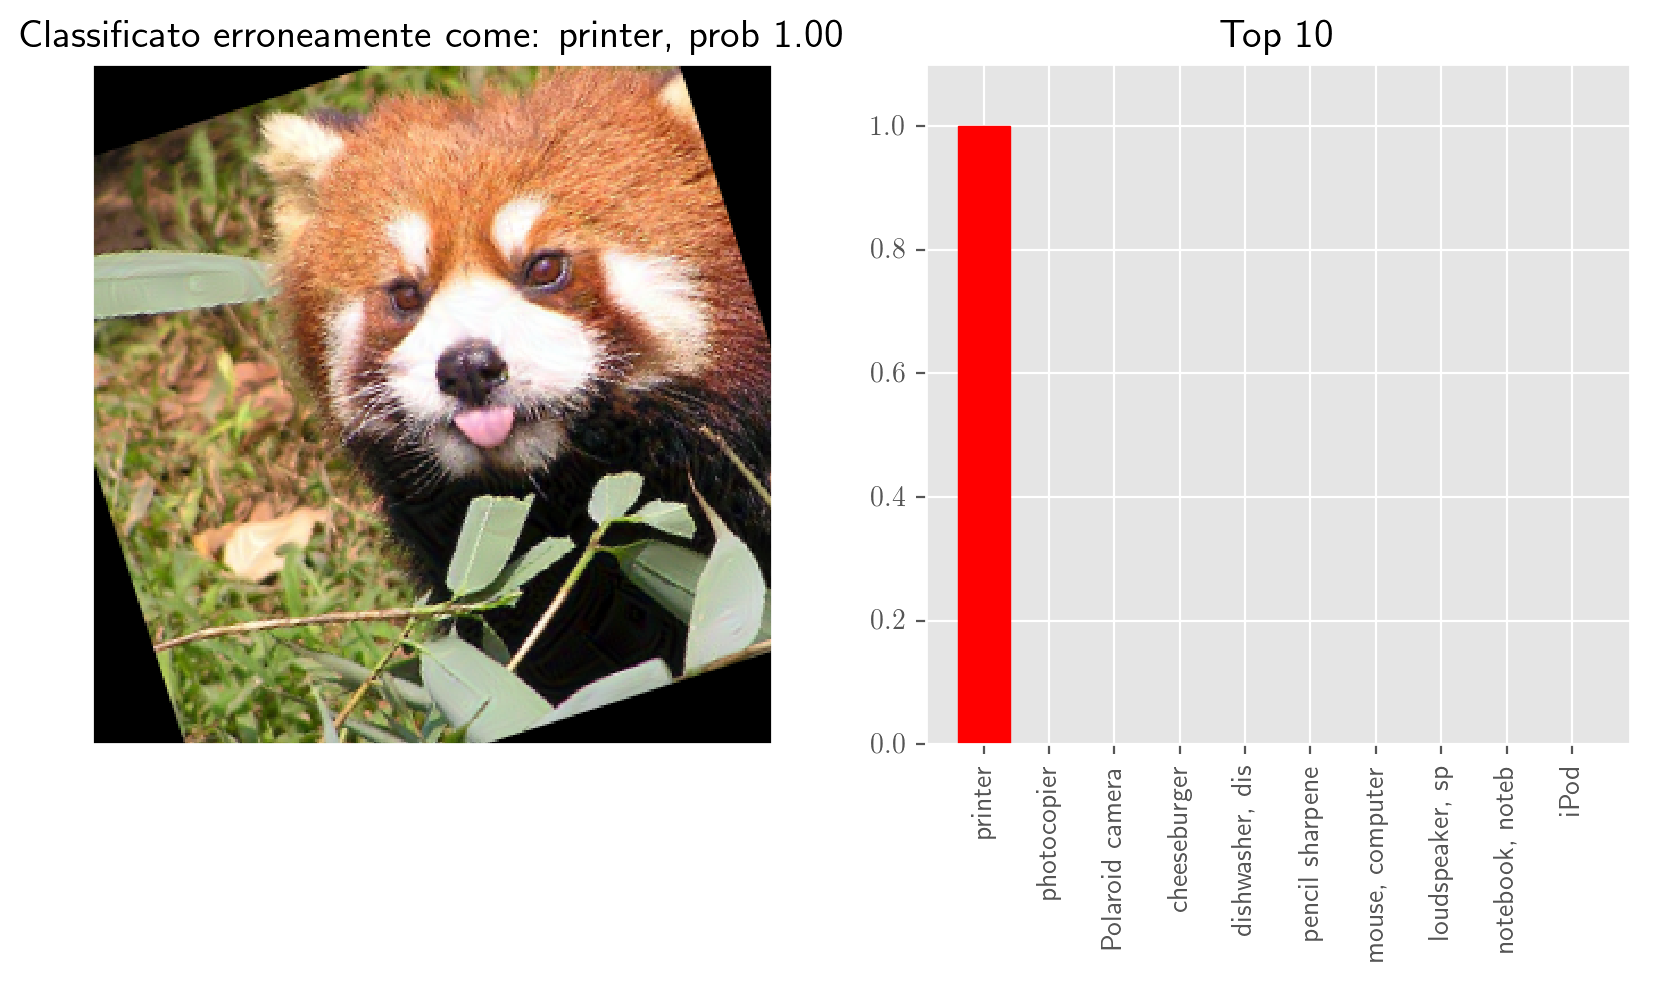

In [60]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
_,_= classify(rotated_example, correct_class=img_class, target_class=demo_target)

un confronto, al variare dell'angolo di rotazione dell'immagine, tra l'esempio "robusto" ottenuto col secondo metodo, e l'esempio "naive" ne dimostra l'efficacia, confrontiamo [graficamente](https://www.youtube.com/watch?v=sIlNIVXpIns) la robustezza dei due metodi su un angolo di rotazione da $- \pi /4 $ e $ + \pi/4$: 

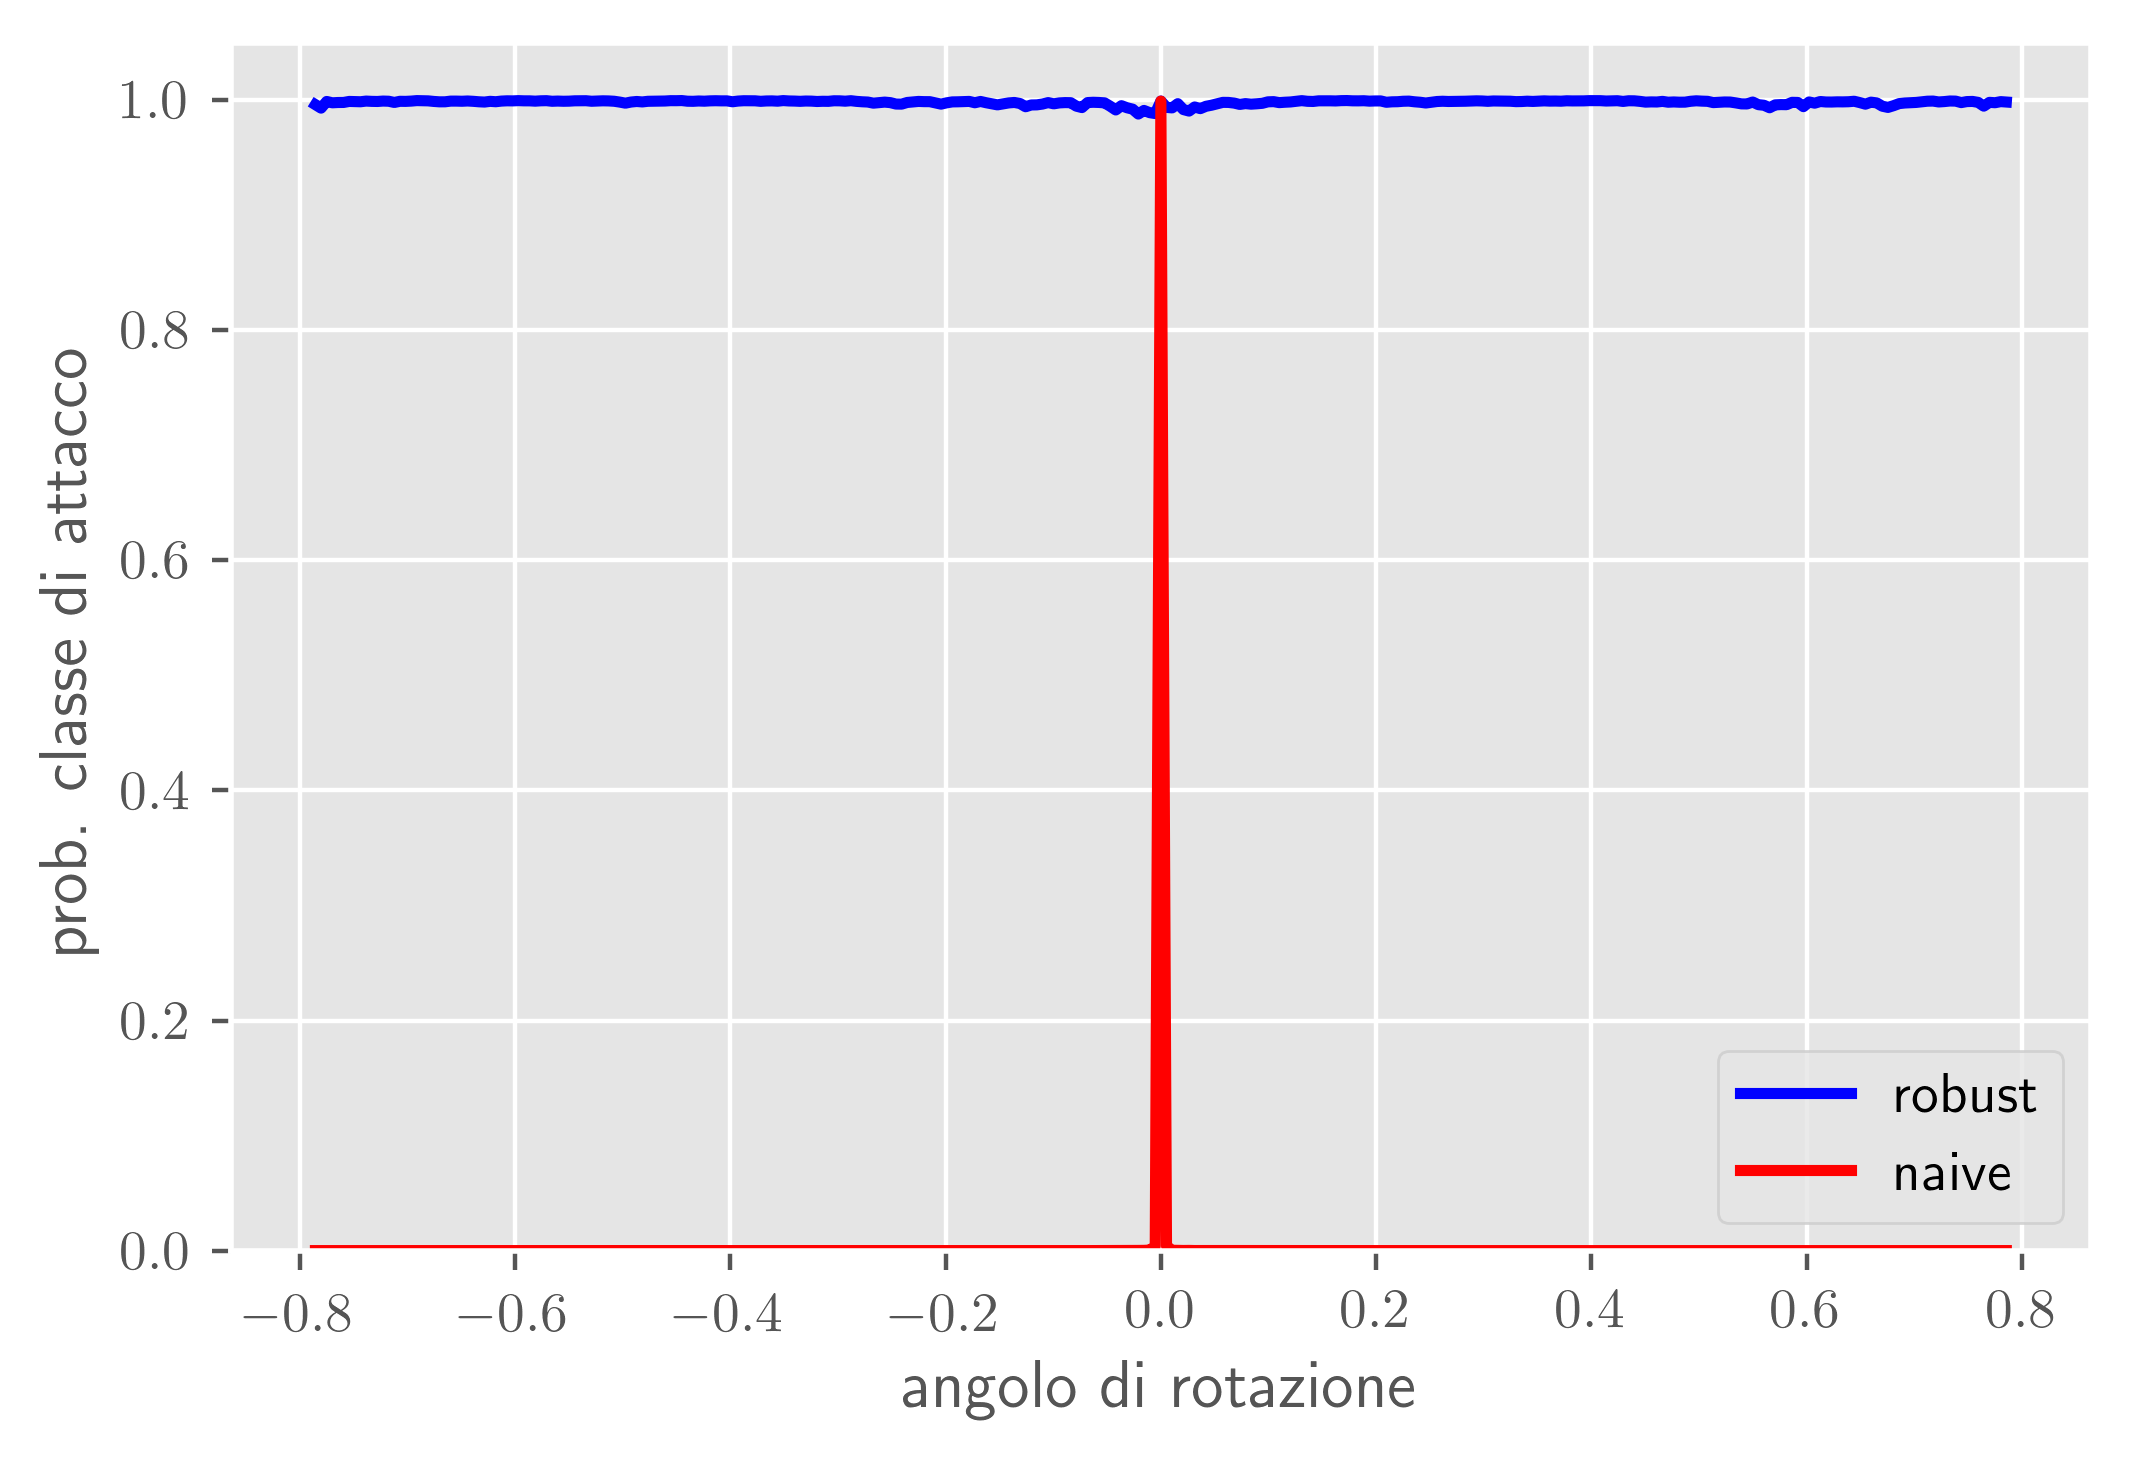

In [61]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('angolo di rotazione')
plt.ylabel('prob. classe di attacco')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()

Come vediamo il metodo FGSM non è robusto rispetto a rotazioni, anche piccole, mentre il secondo metodo produce immagini che restano avversariali anche sotto rotazioni. 
Il metodo è estendibile ad una vastissima gamma di trasformazioni, nel nostro caso abbiamo utilizzato solo rotazioni per motivi di sforzo computazionale (senza una GPU questo notebook può richiedere fino a un'ora e mezza per essere eseguito).